In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
# from dynamic_routing_analysis import decoding_utils
# from dynamic_routing_analysis import plot_utils
# import dynamic_routing_analysis as dra
import pingouin as pg
import os
import random

import matplotlib
import matplotlib.font_manager as fm

matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
fm.FontProperties().set_family('arial')

%load_ext autoreload
%autoreload 2
%matplotlib inline
# %matplotlib widget
# %matplotlib notebook

In [ ]:
# results_path="s3://aind-scratch-data/dynamic-routing/decoding/results/time_mod_vis_target_0/"
# results_path="s3://aind-scratch-data/dynamic-routing/decoding/results/time_mod_aud_target_0/"
results_path="s3://aind-scratch-data/dynamic-routing/decoding/results/time_mod_keep_units_consistent_0/"

#try nonlinear decoders
# results_path="s3://aind-scratch-data/dynamic-routing/decoding/results/test_nonlinearSVC_multi_timebin_0/"
# results_path="s3://aind-scratch-data/dynamic-routing/decoding/results/test_RandomForest_multi_timebin_0/"

#smaller time bins
# results_path="s3://aind-scratch-data/dynamic-routing/decoding/results/test_0.05s_multi_timebin_0/"
# results_path="s3://aind-scratch-data/dynamic-routing/decoding/results/test_0_1s_multi_timebin_0/"

# baseline subtracted, lick decoding
# results_path = "s3://aind-scratch-data/dynamic-routing/decoding/results/test_baseline_subtracted_0/"
# results_path = "s3://aind-scratch-data/dynamic-routing/decoding/results/test_decoding_licks_0/"
# results_path = "s3://aind-scratch-data/dynamic-routing/decoding/results/test_decoding_licks_baseline_subtracted_1/"

#baseline subtracted, sliding window
# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/baseline_subtract_10ms_step_50ms_window_0/"
# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/baseline_subtract_10ms_step_50ms_window_0_aud_target_0/"
# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/baseline_subtract_10ms_step_50ms_window_0_vis_target_0/"

# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/baseline_subtract_10ms_step_50ms_window_decode_response_0/"
# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/baseline_subtract_10ms_step_50ms_window_decode_response_0_aud_target_0/"
# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/baseline_subtract_10ms_step_50ms_window_decode_response_0_vis_target_0/"

# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_context_10ms_no_baseline_subtract_0/"
# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/baseline_subtract_10ms_step_50ms_window_decode_response_0/"
# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_all_stimuli_10ms_bins_0/"

#separate by stimulus modality
# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_context_no_baseline_subtract_aud_stim_10ms_bins_10_units_0/"
# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_context_no_baseline_subtract_vis_stim_10ms_bins_10_units_0/"

# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_context_aud_stim_500ms_bins_10_units_0/"
# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_context_vis_stim_500ms_bins_10_units_0/"

# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_context_vis_stim_25ms_bins_10_units_0/"
# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_context_aud_stim_25ms_bins_10_units_0/"

# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/response_aligned_decode_context_targets_25ms_0/"
# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/response_aligned_decode_reward_targets_25ms_0/"

# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/response_aligned_decode_context_aud_targets_25ms_1/"
# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/response_aligned_decode_context_vis_targets_25ms_1/"


#25ms bins with 100ms window
# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_context_aud_stim_25ms_bin_100ms_window_w_repeats_0/"
# results_path = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_context_vis_stim_25ms_bin_100ms_window_w_repeats_0/"

# results_path=r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_context_baseline_subtract_aud_target_correct_trials_5ms_bin_50ms_window_20251108_000039/"
# results_path=r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_context_baseline_subtract_vis_target_correct_trials_5ms_bin_50ms_window_20251107_235739/"

# results_path=r"s3://aind-scratch-data/dynamic-routing/decoding/results/test_custom_unit_filter_20260205_215951/"

In [3]:
session_table_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\session_table_v0.272.parquet"
# session_table_path="/Users/ethan.mcbride/Data/DR/session_table_v0.265.csv"
session_table=pl.read_parquet(session_table_path)

dr_session_list=(
    session_table.filter(
    pl.col('project')=="DynamicRouting",
    pl.col('is_production'),
    pl.col('is_annotated'),
    pl.col('issues')==[],
    # pl.col('is_engaged'),
    # pl.col('is_good_behavior').eq(True),
    )['session_id'].to_list()
    )

In [4]:
#define grouping columns
grouping_cols = {
    'session_id',
    'structure',
    'electrode_group_names',
    'unit_subsample_size',
    'bin_center',
    'bin_size',
    'time_aligned_to',
    # 'unit_criteria',
}

#toggle combine_multi_probe_rec
combine_multi_probe_rec = True

if combine_multi_probe_rec:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().gt(1) | pl.col('is_sole_recording').eq(True)
else:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().eq(1) | pl.col('is_sole_recording').eq(True)


In [ ]:
# session-wise average decoding accuracy
structure_grouping = {
    'SCop': 'SCs',
    'SCsg': 'SCs',
    'SCzo': 'SCs',
    'SCig': 'SCm',
    'SCiw': 'SCm',
    'SCdg': 'SCm',
    'SCdw': 'SCm',
    "ECT1": 'ECT',
    "ECT2/3": 'ECT',    
    "ECT6b": 'ECT',
    "ECT5": 'ECT',
    "ECT6a": 'ECT', 
    "ECT4": 'ECT',
}
keep_original_structure = False
if keep_original_structure:
    n_repeats = 2
else:
    n_repeats = 1

#add total n units, cross-modal dprime, n good blocks?

new_results_session_df = (
    pl.scan_parquet(results_path)
    .filter(
        pl.col('session_id').is_in(dr_session_list),
    )
    .with_columns(
        pl.col('electrode_group_names').flatten().n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),
    )
    .filter(
        combine_multi_probe_expr,
        pl.col('is_all_trials').not_(),
    )
    #get total n units
    .join(
        other=(
            pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.272/consolidated/units.parquet')
            .with_columns(
                pl.col('session_id').str.split('_').list.slice(0, 2).list.join('_'),
            )
            #make new rows according to structure_grouping
            .with_columns(
                pl.when(pl.col('structure').is_in(structure_grouping.keys()))
                .then(pl.col('structure').repeat_by(n_repeats))
                .otherwise(pl.col('structure').repeat_by(1))
            )
            .explode('structure')
            .with_columns(
                pl.when(pl.col('structure').is_in(structure_grouping.keys()).is_first_distinct().over('unit_id'))
                .then(pl.col('structure').replace(structure_grouping))
                .otherwise(pl.col('structure'))
            )
            .group_by('session_id','structure')
            .agg(
                pl.col('unit_id').len().alias('total_n_units')
            )
        ),
        on=['session_id','structure'],
        how='left',
    )
    #join on session table to get cross-modal dprime, etc.
    .join(
        other=session_table.filter(
            pl.col('session_id').is_in(dr_session_list)
        ).select(
            'session_id',
            'n_passing_blocks',
            'cross_modality_dprime_vis_blocks',
            'cross_modality_dprime_aud_blocks',
        ).lazy(),
        on='session_id',
        how='left',
    )
    # get the means for each recording over repeats:
    .group_by(grouping_cols | {'shift_idx', 'n_passing_blocks', 'cross_modality_dprime_vis_blocks', 
                               'cross_modality_dprime_aud_blocks', 'total_n_units'}, maintain_order=True)
    .agg(
        pl.col('balanced_accuracy_test').mean(), # over repeats
    )
    # get the aligned result and median over shifts:
    .group_by(grouping_cols - {'electrode_group_names'} | {'n_passing_blocks', 'cross_modality_dprime_vis_blocks', 
                                                           'cross_modality_dprime_aud_blocks', 'total_n_units'})
    .agg(
        pl.col('balanced_accuracy_test').filter(pl.col('shift_idx') == 0).first().alias('mean_true'),
        pl.col('balanced_accuracy_test').filter(pl.col('shift_idx') != 0).median().alias('median_null'),
        pl.col('balanced_accuracy_test', 'shift_idx').sort_by('shift_idx'),
    )
    # get the difference between true and null:
    .with_columns(
        pl.col('mean_true').sub(pl.col('median_null')).alias('mean_diff'),
    )
    .sort('structure', 'unit_subsample_size', descending=False)
    .collect()
)


In [ ]:
# new_results_session_df.sort(
#     pl.col('mean_diff'),
#     maintain_order=True,
# )

In [9]:
new_results_session_pd=new_results_session_df.to_pandas()

In [ ]:
new_results_session_pd.to_parquet(r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\baseline_subtract_10ms_step_50ms_window_decode_response_0_2025-09-03\decoder_accuracy_by_session.parquet", index=False)
# new_results_session_pd.to_parquet(r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\DR CO decoding results\rewarded_modality_1.5sec_0_2025-06-23\decoder_accuracy_by_session.parquet",index=False)

In [ ]:
# new_results_session_pd=pd.read_parquet("/Users/ethan.mcbride/Data/DR/time_mod_binsize_0.5_sec_0_2025_05-19/decoder_accuracy_by_session.parquet")
# new_results_session_pd=pd.read_parquet(r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\DR CO decoding results\context_appropriate_response_1.5sec_0_2025-06-23\decoder_accuracy_by_session.parquet")

In [10]:
new_results_session_pd

,structure,bin_center,session_id,cross_modality_dprime_aud_blocks,total_n_units,n_passing_blocks,bin_size,time_aligned_to,unit_subsample_size,cross_modality_dprime_vis_blocks,mean_true,median_null,balanced_accuracy_test,shift_idx,mean_diff
0,CP,0.535,742903_2024-10-22,"[3.612305018606193, 2.0867242116239924, 2.6866...",265,5,0.01,stim_start_time,10,"[2.5552824516124693, 2.7871194607459593, 0.779...",NaN,NaN,[0.7850091786283891],[nan],NaN
1,CP,0.085,742903_2024-10-22,"[3.612305018606193, 2.0867242116239924, 2.6866...",265,5,0.01,stim_start_time,10,"[2.5552824516124693, 2.7871194607459593, 0.779...",NaN,NaN,[0.6409545853269537],[nan],NaN
2,CP,0.435,742903_2024-10-22,"[3.612305018606193, 2.0867242116239924, 2.6866...",265,5,0.01,stim_start_time,10,"[2.5552824516124693, 2.7871194607459593, 0.779...",NaN,NaN,[0.759416028708134],[nan],NaN
3,CP,0.095,742903_2024-10-22,"[3.612305018606193, 2.0867242116239924, 2.6866...",265,5,0.01,stim_start_time,10,"[2.5552824516124693, 2.7871194607459593, 0.779...",NaN,NaN,[0.6666951355661881],[nan],NaN
4,CP,0.515,742903_2024-10-22,"[3.612305018606193, 2.0867242116239924, 2.6866...",265,5,0.01,stim_start_time,10,"[2.5552824516124693, 2.7871194607459593, 0.779...",NaN,NaN,[0.8012269059011164],[nan],NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,SSp,0.515,742903_2024-10-22,"[3.612305018606193, 2.0867242116239924, 2.6866...",857,5,0.01,stim_start_time,10,"[2.5552824516124693, 2.7871194607459593, 0.779...",NaN,NaN,[0.6933782775119617],[nan],NaN
346,SSp,-0.035,742903_2024-10-22,"[3.612305018606193, 2.0867242116239924, 2.6866...",857,5,0.01,stim_start_time,10,"[2.5552824516124693, 2.7871194607459593, 0.779...",NaN,NaN,[0.5319144816586922],[nan],NaN
347,SSp,0.445,742903_2024-10-22,"[3.612305018606193, 2.0867242116239924, 2.6866...",857,5,0.01,stim_start_time,10,"[2.5552824516124693, 2.7871194607459593, 0.779...",NaN,NaN,[0.7023965071770334],[nan],NaN
348,SSp,0.115,742903_2024-10-22,"[3.612305018606193, 2.0867242116239924, 2.6866...",857,5,0.01,stim_start_time,10,"[2.5552824516124693, 2.7871194607459593, 0.779...",NaN,NaN,[0.5376055342902711],[nan],NaN


In [ ]:
new_results_session_pd.query('session_id=="670180_2023-07-27" and structure=="MOs" and \
                             time_aligned_to=="stim_start_time" and unit_subsample_size==20').sort_values('bin_center')

In [ ]:
# new_results_session_pd['session_id'].unique()
new_results_session_pd.query('session_id=="664851_2023-11-13"')['structure'].unique()

In [16]:
new_results_session_pd['bin_center']=new_results_session_pd['bin_center'].round(3)

Text(0.5, 1.0, '742903_2024-10-22; MOs; stim_start_time; 10 units')

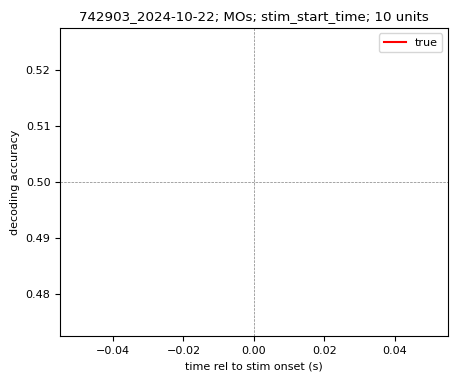

In [17]:
sel_session="742903_2024-10-22"
# sel_session="664851_2023-11-13"
# sel_session="670180_2023-07-27"
sel_structure="MOs"
sel_unit_subsample_size=10
sel_time_aligned_to="stim_start_time"
# sel_time_aligned_to="response_or_reward_time"

# example_timebin_decoding=new_results_session_pd.query('session_id=="664851_2023-11-13" and structure=="ACAd" and \
#                                                     time_aligned_to=="stim_start_time" and unit_subsample_size==20').sort_values('bin_center')
example_timebin_decoding=new_results_session_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
                                                     time_aligned_to=="{sel_time_aligned_to}" and unit_subsample_size=={sel_unit_subsample_size}').sort_values('bin_center')
# example_timebin_decoding=new_results_session_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
#                                                      time_aligned_to=="{sel_time_aligned_to}"').sort_values('bin_center')

fig,ax=plt.subplots(1,1,figsize=(5,4))

ax.axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
# ax.axvline(x=0.5, color='grey', linestyle='--', linewidth=0.5)
ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.5)

ax.plot(example_timebin_decoding['bin_center']+.025, example_timebin_decoding['mean_true'], label='true', color='red')
# ax.plot(example_timebin_decoding['bin_center'], example_timebin_decoding['median_null'], label='null', color='black')

# ax.plot(example_timebin_decoding['bin_center'], example_timebin_decoding['mean_diff']+0.5, label='mean_diff+0.5', color='red')

# ax.set_ylim(0.5,1)
# ax.set_xlim(-0.2,0.7)

ax.set_xlabel('time rel to stim onset (s)')
ax.set_ylabel('decoding accuracy')
ax.legend()
ax.set_title(f"{sel_session}; {sel_structure}; {sel_time_aligned_to}; {sel_unit_subsample_size} units")

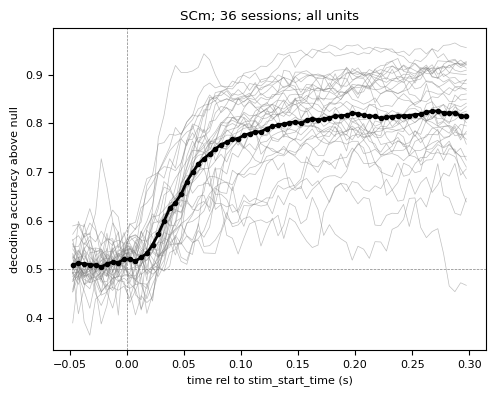

In [47]:
#example area average from good sessions

sel_structure="SCm"
time_aligned_to="stim_start_time"
# time_aligned_to="response_or_reward_time"
min_n_passing_blocks=4

structure_accuracy=np.vstack(new_results_session_pd.query(
    'n_passing_blocks>=@min_n_passing_blocks and structure==@sel_structure and time_aligned_to==@time_aligned_to'
    ).sort_values(
        ['session_id','bin_center']
        ).groupby(['session_id'])['mean_true'].apply(np.array).values)

bins=np.vstack(new_results_session_pd.query(
    'n_passing_blocks>=@min_n_passing_blocks and structure==@sel_structure and time_aligned_to==@time_aligned_to'
    ).sort_values(
        ['session_id','bin_center']
        ).groupby(['session_id'])['bin_center'].apply(np.array).values)[0]

n_sessions=len(structure_accuracy)

fig,ax=plt.subplots(1,1,figsize=(5,4))
ax.axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.5)
ax.plot(bins,structure_accuracy.T, color='grey', alpha=0.5, linewidth=0.5)
ax.plot(bins,np.nanmean(structure_accuracy,axis=0), color='black', marker='.', linewidth=2)

ax.set_title(f"{sel_structure}; {n_sessions} sessions; {sel_unit_subsample_size} units")
ax.set_xlabel('time rel to '+time_aligned_to+' (s)')
ax.set_ylabel('decoding accuracy above null')

fig.tight_layout()

In [ ]:
#average over areas from good sessions

time_aligned_to="stim_start_time"
min_n_passing_blocks=4

mean_timemod_accuracy_by_structure={
    'structure':[],
    'mean_diff':[],
    'mean_diff_std':[],
    'mean_diff_sem':[],
    'n_sessions':[],
}

for sel_structure in new_results_session_pd.query('n_passing_blocks>=4')['structure'].unique():
    structure_accuracy=np.vstack(new_results_session_pd.query(
        'n_passing_blocks>=@min_n_passing_blocks and structure==@sel_structure and time_aligned_to==@time_aligned_to'
        ).sort_values(
            ['session_id','bin_center']
            ).groupby(['session_id'])['mean_diff'].apply(np.array).values)

    bins=np.vstack(new_results_session_pd.query(
        'n_passing_blocks>=@min_n_passing_blocks and structure==@sel_structure and time_aligned_to==@time_aligned_to'
        ).sort_values(
            ['session_id','bin_center']
            ).groupby(['session_id'])['bin_center'].apply(np.array).values)[0]
    
    n_sessions=len(structure_accuracy)

    mean_timemod_accuracy_by_structure['structure'].append(sel_structure)
    mean_timemod_accuracy_by_structure['mean_diff'].append(np.nanmean(structure_accuracy,axis=0))
    mean_timemod_accuracy_by_structure['mean_diff_std'].append(np.nanstd(structure_accuracy,axis=0))
    mean_timemod_accuracy_by_structure['mean_diff_sem'].append(stats.sem(structure_accuracy, axis=0, nan_policy='omit'))
    mean_timemod_accuracy_by_structure['n_sessions'].append(n_sessions)

mean_timemod_accuracy_by_structure_df=pd.DataFrame(mean_timemod_accuracy_by_structure)

In [ ]:
# mean_timemod_accuracy_by_structure_df
np.mean(np.diff(bins))/2

In [ ]:
structure_matrix=np.vstack(mean_timemod_accuracy_by_structure_df.query('n_sessions>=3')['mean_diff'].values)
structure_labels=mean_timemod_accuracy_by_structure_df.query('n_sessions>=3')['structure'].values

fig,ax=plt.subplots(1,1,figsize=(5,6))
im=ax.imshow(structure_matrix, aspect='auto', cmap='viridis', vmin=0, vmax=0.15, 
             extent=[bins[0]-np.mean(np.diff(bins))/2, bins[-1]+np.mean(np.diff(bins))/2, len(structure_labels), 0])
ax.set_yticks(np.arange(len(structure_labels))+0.5, structure_labels, ha='right')
# ax.set_xticks(np.arange(len(bins)))
# ax.set_xticklabels(bins)
ax.set_xlabel('time rel to '+time_aligned_to+' (s)')
ax.set_ylabel('structure')

# ax.set_title(f"mean decoding accuracy above null; {sel_unit_subsample_size} units; {min_n_passing_blocks} blocks")

fig.colorbar(im, ax=ax, label='decoding accuracy above null')
fig.tight_layout()

In [ ]:
bins

## trialwise analysis

In [18]:

predict_proba_alias='predict_proba'

structure_grouping = {
    'SCop': 'SCs',
    'SCsg': 'SCs',
    'SCzo': 'SCs',
    'SCig': 'SCm',
    'SCiw': 'SCm',
    'SCdg': 'SCm',
    'SCdw': 'SCm',
    "ECT1": 'ECT',
    "ECT2/3": 'ECT',    
    "ECT6b": 'ECT',
    "ECT5": 'ECT',
    "ECT6a": 'ECT', 
    "ECT4": 'ECT',
}
keep_original_structure = False
if keep_original_structure:
    n_repeats = 2
else:
    n_repeats = 1

predict_proba_wo_repeats = (
    pl.scan_parquet(results_path)
    #make new column that indicates whether a row is the sole recording from a structure in a session
    .with_columns(
        pl.col('electrode_group_names').flatten().n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),     
    )
    #Grab only rows according to combine_multi_probe_rec toggle
    #Grab only rows that have is_all_trials == True, only these have predict_proba
    .filter(
        combine_multi_probe_expr,
        pl.col('is_all_trials'),
    )
    #join on the units table to get total number of units per structure
    .join(
        other=(
            pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.268/consolidated/units.parquet')
            .with_columns(
                pl.col('session_id').str.split('_').list.slice(0, 2).list.join('_'),
            )
            #make new rows according to structure_grouping
            .with_columns(
                pl.when(pl.col('structure').is_in(structure_grouping.keys()))
                .then(pl.col('structure').repeat_by(n_repeats))
                .otherwise(pl.col('structure').repeat_by(1))
            )
            .explode('structure')
            .with_columns(
                pl.when(pl.col('structure').is_in(structure_grouping.keys()).is_first_distinct().over('unit_id'))
                .then(pl.col('structure').replace(structure_grouping))
                .otherwise(pl.col('structure'))
            )
            .group_by('session_id','structure')
            .agg(
                pl.col('unit_id').len().alias('total_n_units')
            )
        ),
        on=['session_id','structure'],
        how='left',
    )
    .with_columns(
        pl.col('trial_indices').alias('trial_index')
        #pl.int_ranges(0, pl.col(predict_proba_alias).list.len()).alias('trial_index')
    )
    .drop('shift_idx', 'is_all_trials', 'electrode_group_names', 'unit_criteria', 'is_sole_recording')
    .explode(predict_proba_alias, 'trial_index')
    .group_by('session_id', 'structure', 'unit_subsample_size', 'trial_index', 'bin_center', 'bin_size', 'time_aligned_to',)
    .agg(
        pl.col('balanced_accuracy_test').mean(),
        pl.col(predict_proba_alias).mean().alias('predict_proba'),
        pl.col('total_n_units').first(),
        # pl.col('unit_ids').first(),
    )
    .join(
        other=(
            pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.268/consolidated/trials.parquet')
            .with_columns(
                pl.col('session_id').str.split('_').list.slice(0, 2).list.join('_'),
                #iti column?
            )
            .select('session_id', 'trial_index', 'is_vis_rewarded', 'stim_name', 'is_response')
        ),
        on=['session_id','trial_index'],
        how='inner',
    ) 
    .group_by('session_id', 'structure', 'unit_subsample_size', 'bin_center', 'time_aligned_to',)
    .agg(
        pl.col('balanced_accuracy_test').first(),
        pl.col('total_n_units').first(),
        # pl.col('unit_ids').first(),
        pl.col('predict_proba', 'trial_index', 'is_vis_rewarded', 'stim_name', 'is_response').sort_by('trial_index'),

    )
    .sort('session_id','structure', 'unit_subsample_size', 'bin_center')
    # .group_by('session_id','structure')
    .collect(engine='streaming')
)

In [19]:
predict_proba_pd=predict_proba_wo_repeats.to_pandas()

In [ ]:
# predict_proba_pd.to_parquet(r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\time_mod_keep_units_consistent_0_2025-06-15\predict_proba_by_session.parquet", index=False)

In [20]:
predict_proba_pd

,session_id,structure,unit_subsample_size,bin_center,time_aligned_to,balanced_accuracy_test,total_n_units,predict_proba,trial_index,is_vis_rewarded,stim_name,is_response
0,742903_2024-10-22,CP,10,-0.095,stim_start_time,0.527506,265,"[0.49679268307987945, 0.49982453041673786, 0.4...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[False, False, False, False, False, False, Fal...","[sound1, sound1, sound1, sound1, sound1, sound...","[True, True, True, True, True, True, True, Tru..."
1,742903_2024-10-22,CP,10,-0.085,stim_start_time,0.512035,265,"[0.4781009057188772, 0.49149196818359037, 0.49...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[False, False, False, False, False, False, Fal...","[sound1, sound1, sound1, sound1, sound1, sound...","[True, True, True, True, True, True, True, Tru..."
2,742903_2024-10-22,CP,10,-0.075,stim_start_time,0.488547,265,"[0.48013581033629665, 0.48939580736496474, 0.4...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[False, False, False, False, False, False, Fal...","[sound1, sound1, sound1, sound1, sound1, sound...","[True, True, True, True, True, True, True, Tru..."
3,742903_2024-10-22,CP,10,-0.065,stim_start_time,0.487580,265,"[0.49995866906564884, 0.48931484153138, 0.4899...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[False, False, False, False, False, False, Fal...","[sound1, sound1, sound1, sound1, sound1, sound...","[True, True, True, True, True, True, True, Tru..."
4,742903_2024-10-22,CP,10,-0.055,stim_start_time,0.528268,265,"[0.5012311606240868, 0.5555868396438386, 0.484...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[False, False, False, False, False, False, Fal...","[sound1, sound1, sound1, sound1, sound1, sound...","[True, True, True, True, True, True, True, Tru..."
...,...,...,...,...,...,...,...,...,...,...,...,...
345,742903_2024-10-22,SSp,10,0.555,stim_start_time,0.698326,857,"[0.7345402797114556, 0.7271627733058211, 0.724...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[False, False, False, False, False, False, Fal...","[sound1, sound1, sound1, sound1, sound1, sound...","[True, True, True, True, True, True, True, Tru..."
346,742903_2024-10-22,SSp,10,0.565,stim_start_time,0.697285,857,"[0.612734882240488, 0.7512874357627923, 0.7338...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[False, False, False, False, False, False, Fal...","[sound1, sound1, sound1, sound1, sound1, sound...","[True, True, True, True, True, True, True, Tru..."
347,742903_2024-10-22,SSp,10,0.575,stim_start_time,0.699548,857,"[0.6215679175165097, 0.649356447259429, 0.7491...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[False, False, False, False, False, False, Fal...","[sound1, sound1, sound1, sound1, sound1, sound...","[True, True, True, True, True, True, True, Tru..."
348,742903_2024-10-22,SSp,10,0.585,stim_start_time,0.695242,857,"[0.6898205236279452, 0.5433731784484458, 0.747...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[False, False, False, False, False, False, Fal...","[sound1, sound1, sound1, sound1, sound1, sound...","[True, True, True, True, True, True, True, Tru..."


In [ ]:
# predict_proba_pd=pd.read_parquet("/Users/ethan.mcbride/Data/DR/time_mod_binsize_0.5_sec_0_2025_05-19/predict_proba_by_session.parquet")
# predict_proba_pd=pd.read_parquet(r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\DR CO decoding results\time_mod_binsize_0.5_sec_0_2025_05-19\predict_proba_by_session.parquet")

In [21]:
#add project column to predict_proba_pd and filter to just one time bin
predict_proba_temp=predict_proba_pd.query('bin_center==-0.025')

project_list = []
for rr, row in predict_proba_temp.iterrows():
    project= session_table.filter(
        pl.col('session_id') == row['session_id']
    )['project'][0]
    project_list.append(project)

predict_proba_temp['project'] = project_list

In [ ]:
predict_proba_temp.to_parquet(r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\time_mod_keep_units_consistent_0_2025-06-15\predict_proba_by_session_single_timebin.parquet", index=False)
predict_proba_temp

In [22]:
sel_session="742903_2024-10-22"
sel_structure="MOs"
sel_unit_subsample_size=10
sel_time_aligned_to='stim_start_time'

# ###hack used until we add trial_index to the results
# if sel_time_aligned_to=='response_time':
#     if sel_unit_subsample_size=='all':
#         temp_trial_info=predict_proba_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
#                                                         time_aligned_to=="stim_start_time" and unit_subsample_size.isna()'
#                                                         ).sort_values('bin_center').iloc[0]
#     else:
#         temp_trial_info=predict_proba_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
#                                                 time_aligned_to=="stim_start_time" and unit_subsample_size=={sel_unit_subsample_size}'
#                                                 ).sort_values('bin_center').iloc[0]
    
#     trial_index=temp_trial_info['trial_index'][temp_trial_info['is_response']]
#     is_vis_rewarded=temp_trial_info['is_vis_rewarded'][temp_trial_info['is_response']]
#     stim_name=temp_trial_info['stim_name'][temp_trial_info['is_response']]
#     is_response=temp_trial_info['is_response'][temp_trial_info['is_response']]

#     if sel_unit_subsample_size=='all':
#         example_area_results=predict_proba_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
#                                                     time_aligned_to=="response_time" and unit_subsample_size.isna()'
#                                                     ).sort_values('bin_center').reset_index(drop=True)
#     else:
#         example_area_results=predict_proba_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
#                                                     time_aligned_to=="response_time" and unit_subsample_size=={sel_unit_subsample_size}'
#                                                     ).sort_values('bin_center').reset_index(drop=True)
#     trial_index_list=[]
#     is_vis_rewarded_list=[]
#     stim_name_list=[]
#     is_response_list=[]
#     for rr in range(len(example_area_results)):
#         trial_index_list.append(trial_index)
#         is_vis_rewarded_list.append(is_vis_rewarded)
#         stim_name_list.append(stim_name)
#         is_response_list.append(is_response)

#     example_area_results['trial_index']=trial_index_list
#     example_area_results['is_vis_rewarded']=is_vis_rewarded_list
#     example_area_results['stim_name']=stim_name_list
#     example_area_results['is_response']=is_response_list

# else:
if sel_unit_subsample_size=='all':
    example_area_results=predict_proba_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
                                                        time_aligned_to=="{sel_time_aligned_to}" and unit_subsample_size.isna()'
                                                        ).sort_values('bin_center').reset_index(drop=True)
else:
    example_area_results=predict_proba_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
                                                time_aligned_to=="{sel_time_aligned_to}" and unit_subsample_size=={sel_unit_subsample_size}'
                                                ).sort_values('bin_center').reset_index(drop=True)

np.where(np.concatenate([[0],np.diff(example_area_results['is_vis_rewarded'].iloc[0])]))[0]

array([ 86, 177, 269, 358, 449], dtype=int64)

In [ ]:
# example_area_results.loc[rr,'trial_index']
# trial_index
# example_area_results.iloc[0]

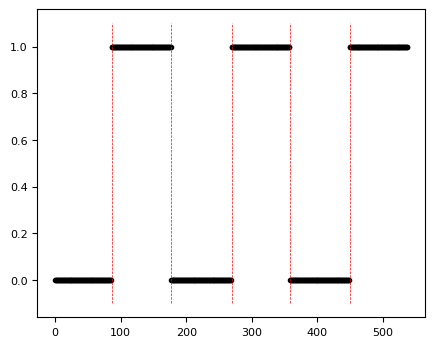

In [23]:
fig,ax=plt.subplots(1,1,figsize=(5,4))

ax.plot(example_area_results['is_vis_rewarded'].iloc[0],'k.')
ax.vlines(x=np.where(np.concatenate([[0],np.diff(example_area_results['is_vis_rewarded'].iloc[0])]))[0],ymin=-.1,ymax=1.1, color='red', linestyle='--', linewidth=0.5)

Text(0.5, 1.0, '742903_2024-10-22; MOs; stim_start_time; 10 units; \n              trial 92; sound1; is_vis_rewarded=True')

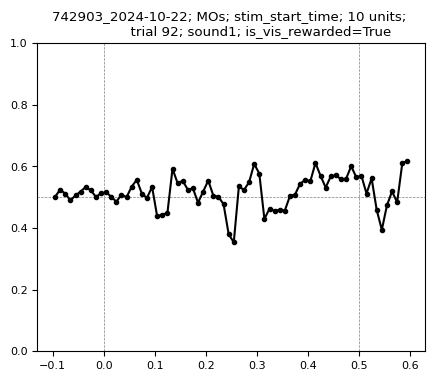

In [24]:
sel_trial=92
fig,ax=plt.subplots(1,1,figsize=(5,4))
ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.5)
ax.axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
ax.axvline(x=0.5, color='grey', linestyle='--', linewidth=0.5)
ax.plot(example_area_results['bin_center'],np.vstack(example_area_results['predict_proba'].values)[:,sel_trial], 'k.-')
ax.set_ylim(0,1)

ax.set_title(f"{sel_session}; {sel_structure}; {sel_time_aligned_to}; {sel_unit_subsample_size} units; \n \
             trial {example_area_results['trial_index'].iloc[0][sel_trial]}; {example_area_results['stim_name'].iloc[0][sel_trial]}; is_vis_rewarded={example_area_results['is_vis_rewarded'].iloc[0][sel_trial]}")

In [ ]:
# is_vis_rewarded

Text(0.5, 1.0, '742903_2024-10-22; MOs; stim_start_time; 10 units')

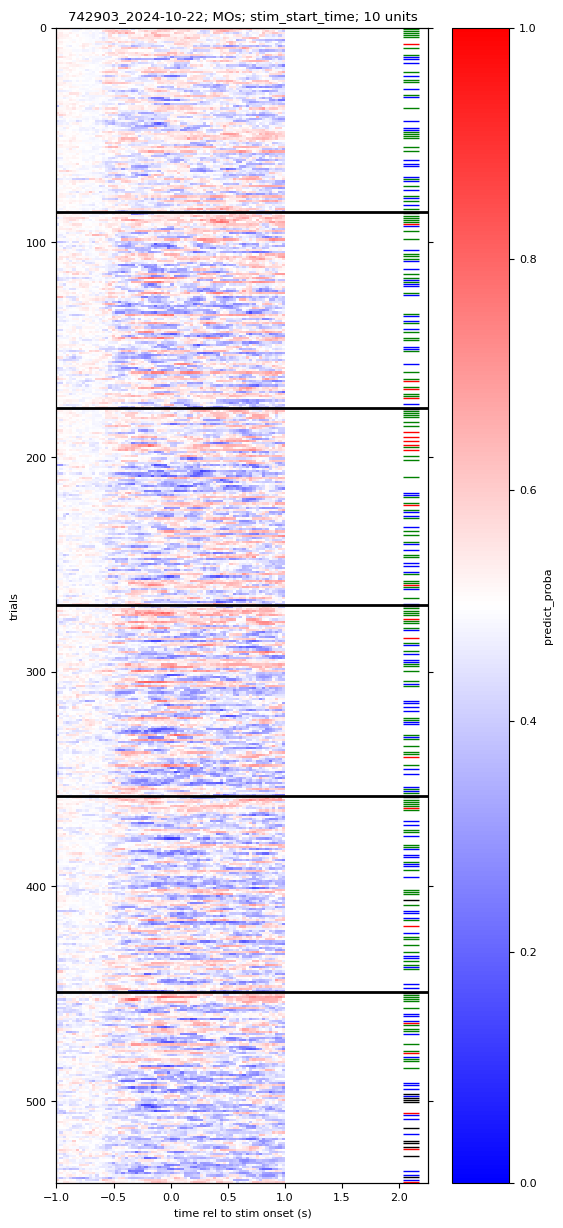

In [25]:
predict_proba_stack=np.vstack(example_area_results['predict_proba'].values).T

fig,ax=plt.subplots(1,1,figsize=(6,15))
im=ax.imshow(predict_proba_stack, aspect='auto', interpolation='none', extent=[-1.0, 1.0, predict_proba_stack.shape[0],0], cmap='bwr', vmin=0, vmax=1)

#colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('predict_proba')

#make tickmarks on right side for false alarms
is_vis_rewarded=example_area_results['is_vis_rewarded'].values[0]
stim_name=example_area_results['stim_name'].values[0]
is_response=example_area_results['is_response'].values[0]

is_false_alarm=(
    is_vis_rewarded & (stim_name == 'sound1') & (is_response == True) |
    ~is_vis_rewarded & (stim_name == 'vis1') & (is_response == True)
)

is_hit=(
    is_vis_rewarded & (stim_name == 'vis1') & (is_response == True) |
    ~is_vis_rewarded & (stim_name == 'sound1') & (is_response == True)
)

is_correct_reject=(
    is_vis_rewarded & (stim_name == 'sound1') & (is_response == False) |
    ~is_vis_rewarded & (stim_name == 'vis1') & (is_response == False)
)

is_miss=(
    is_vis_rewarded & (stim_name == 'vis1') & (is_response == False) |
    ~is_vis_rewarded & (stim_name == 'sound1') & (is_response == False)
)


ax2=ax.twinx()
# ax2.set_ylim(0, predict_proba_stack.shape[0])
ax2.set_ylim(predict_proba_stack.shape[0],0)

ax2.plot([2.1]*len(np.where(is_hit)[0]), np.where(is_hit)[0]+0.5, 'g_', label='hit', clip_on=False, markersize=12)
ax2.plot([2.1]*len(np.where(is_correct_reject)[0]), np.where(is_correct_reject)[0]+0.5, 'b_', label='correct reject', clip_on=False, markersize=12)
ax2.plot([2.1]*len(np.where(is_false_alarm)[0]), np.where(is_false_alarm)[0]+0.5, 'r_', label='false alarm', clip_on=False, markersize=12)
ax2.plot([2.1]*len(np.where(is_miss)[0]), np.where(is_miss)[0]+0.5, 'k_', label='miss', clip_on=False, markersize=12)

# ax2.set_yticks(np.where(is_false_alarm)[0])
ax2.set_yticklabels([])

#plot context switch lines
context_switches=np.where(np.concatenate([[0],np.diff(example_area_results['is_vis_rewarded'].iloc[0])]))[0]
for rr in range(len(context_switches)):
    ax2.axhline(y=context_switches[rr], color='k', linestyle='-', linewidth=2.0)

ax.set_xlabel('time rel to stim onset (s)')
ax.set_ylabel('trials')
ax.set_title(f"{sel_session}; {sel_structure}; {sel_time_aligned_to}; {sel_unit_subsample_size} units")

In [ ]:
# aggregate predict proba in a smart way over trials & structures


# switches (contingent, non-contingent) + pre,post block dprime + trials_since_switch


# rewards (lick & get reward) + block dprime + is_instruction_trial


# reward prediction errors (lick & get no reward, no lick & get reward?) + block dprime + is_instruction_trial


# average non target, non response



In [ ]:

def get_session_structure_results(predict_proba_pd, sel_session, sel_structure, sel_unit_subsample_size, sel_time_aligned_to):
    """
    Get the results for a specific session and structure.
    """
   
    if sel_unit_subsample_size=='all':
        example_area_results=predict_proba_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
                                                    time_aligned_to=="{sel_time_aligned_to}" and unit_subsample_size.isna()'
                                                    ).sort_values('bin_center').reset_index(drop=True)
    else:
        example_area_results=predict_proba_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
                                                    time_aligned_to=="{sel_time_aligned_to}" and unit_subsample_size=={sel_unit_subsample_size}'
                                                    ).sort_values('bin_center').reset_index(drop=True)
    #get context switches
    is_context_switch=np.concatenate([[0],np.diff(example_area_results['is_vis_rewarded'].iloc[0])]).astype(bool)
    context_switch_list=[]
    for rr in range(len(example_area_results)):
        context_switch_list.append(is_context_switch)
    example_area_results['is_context_switch']=context_switch_list


    return example_area_results

In [27]:
all_performance=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.272/consolidated/performance.parquet').collect()#.to_pandas()
all_trials=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.272/consolidated/trials.parquet').collect()#.to_pandas()

In [ ]:
all_performance

In [ ]:
predict_proba_pd.query('session_id=="670180_2023-07-27"')['structure'].unique()

In [ ]:
predict_proba_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
                        time_aligned_to=="{sel_time_aligned_to}" and unit_subsample_size.isna()'
                        ).sort_values('bin_center').reset_index(drop=True)

In [28]:
#get predict_proba relative to switches, make new table

# sel_session="664851_2023-11-13"
# sel_structure="SCm"
sel_unit_subsample_size=10
sel_time_aligned_to='stim_start_time'
# sel_time_aligned_to='response_or_reward_time'

get_trials_rel_to_switch=[-3,-2,-1,0,1,2,3,4]
all_performance=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.272/consolidated/performance.parquet').collect().to_pandas()
all_trials=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.272/consolidated/trials.parquet').collect().to_pandas()

context_switch_table={
    'session_id':[],
    'structure':[],
    'predict_proba':[],
    'bin_centers':[],
    'unit_subsample_size':[],
    'time_aligned_to':[],
    'trial_index':[],
    'trial_rel_to_switch':[],
    'switch_index_in_session':[],
    'is_response':[],
    'is_vis_rewarded':[],
    'is_contingent_switch':[],
    'stim_name':[],
    'dprime_before_switch':[],
    'dprime_after_switch':[],
}

for sel_session in predict_proba_pd['session_id'].unique():
    if sel_session not in dr_session_list:
        print(f"session {sel_session} not in dr_session_list; skipping")
        continue
    for sel_structure in predict_proba_pd.query('session_id==@sel_session')['structure'].unique():

        #get session-structure results
        example_area_results=get_session_structure_results(predict_proba_pd, sel_session, sel_structure, sel_unit_subsample_size, sel_time_aligned_to)

        predict_proba_stack=np.vstack(example_area_results['predict_proba'].values).T

        session_performance=all_performance.query(f'session_id=="{sel_session}"')
        session_trials=all_trials.query(f'session_id=="{sel_session}"')

        #choose values based on their actual, not implied, trial index
        context_switch_trial_index=session_trials.query('is_block_switch')['trial_index'].values
        trial_index=example_area_results['trial_index'].iloc[0]

        #loop through context switches
        for ii,tt in enumerate(context_switch_trial_index):
            # print(f"Context switch {ii} of {len(context_switch_trial_index)}")
            # print(f"Trial {tt} of {len(example_area_results['is_context_switch'].iloc[0])}")
            dprime_before_switch=session_performance['cross_modality_dprime'].iloc[ii]
            dprime_after_switch=session_performance['cross_modality_dprime'].iloc[ii+1]

            is_contingent_switch=session_trials['is_response'].iloc[tt]

            #get the is_vis_rewarded
            is_vis_rewarded=session_trials['is_vis_rewarded'].iloc[tt]

            for t_diff in get_trials_rel_to_switch:

                adj_tt=np.where(trial_index==tt+t_diff)[0]
                if len(adj_tt) == 0:
                    # print(f"session {sel_session} structure {sel_structure} ERROR:")
                    # print("trial index not found in predict_proba stack;")
                    # print("skipping trial")
                    continue
                else:
                    adj_tt=adj_tt[0]

                if tt+t_diff!=trial_index[adj_tt]:
                    print('ERROR: trial index not matching!!')
                    break
                
                if adj_tt >= predict_proba_stack.shape[0]:
                    print(f"session {sel_session} structure {sel_structure} ERROR:")
                    print("trial index out of bounds of predict_proba stack;")
                    print("skipping trial")
                    continue
                    
                #get trial from predict_proba_stack
                predict_proba_values=predict_proba_stack[adj_tt,:]

                #get the bin center of the trial
                bin_centers=example_area_results['bin_center'].values

                #get the is_response
                is_response=example_area_results['is_response'].iloc[0][adj_tt]

                #get the stim_name
                stim_name=example_area_results['stim_name'].iloc[0][adj_tt]

                #append to the context switch table
                context_switch_table['session_id'].append(sel_session)
                context_switch_table['structure'].append(sel_structure)
                context_switch_table['predict_proba'].append(predict_proba_values)
                context_switch_table['bin_centers'].append(bin_centers)
                context_switch_table['unit_subsample_size'].append(sel_unit_subsample_size)
                context_switch_table['time_aligned_to'].append(sel_time_aligned_to)
                context_switch_table['trial_index'].append(trial_index[adj_tt])
                context_switch_table['trial_rel_to_switch'].append(t_diff)
                context_switch_table['switch_index_in_session'].append(ii)
                context_switch_table['is_response'].append(is_response)
                context_switch_table['is_vis_rewarded'].append(is_vis_rewarded)
                context_switch_table['is_contingent_switch'].append(is_contingent_switch)
                context_switch_table['stim_name'].append(stim_name)
                context_switch_table['dprime_before_switch'].append(dprime_before_switch)
                context_switch_table['dprime_after_switch'].append(dprime_after_switch)

context_switch_table_df=pd.DataFrame(context_switch_table)
# context_switch_table_df


In [ ]:
# predict_proba_stack.shape
# response_trial_index
# sel_session
# rr
# session_performance.columns
# context_switch_table_df.query('session_id=="664851_2023-11-13"')

In [ ]:
predict_proba_pd.query('session_id==@sel_session')['structure'].unique()

In [29]:
context_switch_table_df

,session_id,structure,predict_proba,bin_centers,unit_subsample_size,time_aligned_to,trial_index,trial_rel_to_switch,switch_index_in_session,is_response,is_vis_rewarded,is_contingent_switch,stim_name,dprime_before_switch,dprime_after_switch
0,742903_2024-10-22,CP,"[0.4883305605700599, 0.49507195542128785, 0.49...","[-0.095, -0.08500000000000002, -0.075000000000...",10,stim_start_time,83,-3,0,False,True,False,sound2,3.612305,2.555282
1,742903_2024-10-22,CP,"[0.4861128199456365, 0.4917512483490997, 0.489...","[-0.095, -0.08500000000000002, -0.075000000000...",10,stim_start_time,84,-2,0,True,True,False,sound1,3.612305,2.555282
2,742903_2024-10-22,CP,"[0.48595893415261576, 0.49403758509092893, 0.4...","[-0.095, -0.08500000000000002, -0.075000000000...",10,stim_start_time,85,-1,0,False,True,False,sound2,3.612305,2.555282
3,742903_2024-10-22,CP,"[0.48438244024176264, 0.49156641817296387, 0.4...","[-0.095, -0.08500000000000002, -0.075000000000...",10,stim_start_time,86,0,0,False,True,False,vis1,3.612305,2.555282
4,742903_2024-10-22,CP,"[0.5486744805481871, 0.5054508533354162, 0.375...","[-0.095, -0.08500000000000002, -0.075000000000...",10,stim_start_time,87,1,0,True,True,False,vis1,3.612305,2.555282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,742903_2024-10-22,SSp,"[0.5475062037104379, 0.5069411975435603, 0.469...","[-0.095, -0.08500000000000002, -0.075000000000...",10,stim_start_time,449,0,4,False,True,False,vis1,2.686623,0.779123
196,742903_2024-10-22,SSp,"[0.5124233974023192, 0.5263551887660685, 0.522...","[-0.095, -0.08500000000000002, -0.075000000000...",10,stim_start_time,450,1,4,True,True,False,vis1,2.686623,0.779123
197,742903_2024-10-22,SSp,"[0.48658983993358845, 0.48398819703191115, 0.4...","[-0.095, -0.08500000000000002, -0.075000000000...",10,stim_start_time,451,2,4,True,True,False,vis1,2.686623,0.779123
198,742903_2024-10-22,SSp,"[0.5163244393487152, 0.5358399611434955, 0.585...","[-0.095, -0.08500000000000002, -0.075000000000...",10,stim_start_time,452,3,4,True,True,False,vis1,2.686623,0.779123


In [30]:
#compute pre vs. post diff (2 bins and 3 bins)

delta_predict_proba_2_bins=[]
delta_predict_proba_3_bins=[]

for ii, rr in context_switch_table_df.iterrows():
    
    # get the predict proba for the trial
    predict_proba_trial = np.array(rr['predict_proba'])

    delta_2_bins=predict_proba_trial[-2:].mean() - predict_proba_trial[:2].mean()
    delta_predict_proba_2_bins.append(delta_2_bins)

    delta_3_bins=predict_proba_trial[-3:].mean() - predict_proba_trial[:3].mean()
    delta_predict_proba_3_bins.append(delta_3_bins)

context_switch_table_df['delta_predict_proba_2_bins'] = delta_predict_proba_2_bins
context_switch_table_df['delta_predict_proba_3_bins'] = delta_predict_proba_3_bins

In [ ]:
# temp_predict_proba=context_switch_table_df.iloc[0]['predict_proba']

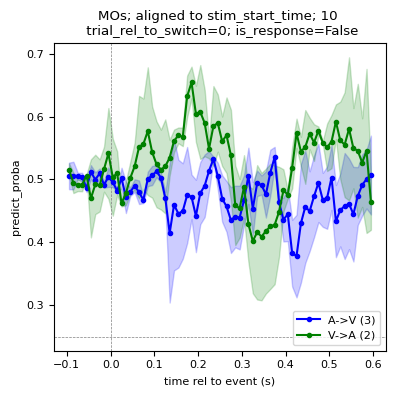

In [33]:
sel_structure='MOs'
sel_trial_rel_to_switch=0
sel_is_response=False

aud_to_vis_switches=context_switch_table_df.query(
    'structure==@sel_structure and is_vis_rewarded==True and is_response==@sel_is_response and trial_rel_to_switch==@sel_trial_rel_to_switch')
vis_to_aud_switches=context_switch_table_df.query(
    'structure==@sel_structure and is_vis_rewarded==False and is_response==@sel_is_response and trial_rel_to_switch==@sel_trial_rel_to_switch')

fig,ax=plt.subplots(1,1,figsize=(4,4))
ax.axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
ax.axhline(y=0.25, color='grey', linestyle='--', linewidth=0.5)

ax.plot(aud_to_vis_switches['bin_centers'].iloc[0], 
        np.nanmean(np.vstack(aud_to_vis_switches['predict_proba'].values),axis=0), 
        label=f'A->V ({len(aud_to_vis_switches)})', color='blue', marker='.')
ax.fill_between(
    aud_to_vis_switches['bin_centers'].iloc[0], 
    np.nanmean(np.vstack(aud_to_vis_switches['predict_proba'].values),axis=0)
    -stats.sem(np.vstack(aud_to_vis_switches['predict_proba'].values),axis=0), 
    np.nanmean(np.vstack(aud_to_vis_switches['predict_proba'].values),axis=0)
    +stats.sem(np.vstack(aud_to_vis_switches['predict_proba'].values),axis=0), 
    color='blue', alpha=0.2)
ax.plot(vis_to_aud_switches['bin_centers'].iloc[0], 
        np.nanmean(np.vstack(vis_to_aud_switches['predict_proba'].values),axis=0),
        label=f'V->A ({len(vis_to_aud_switches)})', color='green', marker='.')
ax.fill_between(
    vis_to_aud_switches['bin_centers'].iloc[0], 
    np.nanmean(np.vstack(vis_to_aud_switches['predict_proba'].values),axis=0)
    -stats.sem(np.vstack(vis_to_aud_switches['predict_proba'].values),axis=0), 
    np.nanmean(np.vstack(vis_to_aud_switches['predict_proba'].values),axis=0)
    +stats.sem(np.vstack(vis_to_aud_switches['predict_proba'].values),axis=0), 
    color='green', alpha=0.2)

# ax.set_ylim(0.2,0.8)
ax.set_xlabel('time rel to event (s)')
ax.set_ylabel('predict_proba')
ax.set_title(f"{sel_structure}; aligned to {sel_time_aligned_to}; {sel_unit_subsample_size} \n trial_rel_to_switch={sel_trial_rel_to_switch}; is_response={sel_is_response}")
ax.legend()
fig.tight_layout()

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_10176\2510141536.py:56: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[xx].legend()
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_10176\2510141536.py:56: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[xx].legend()
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_10176\2510141536.py:56: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[xx].legend()
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_10176\2510141536.py:56: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when

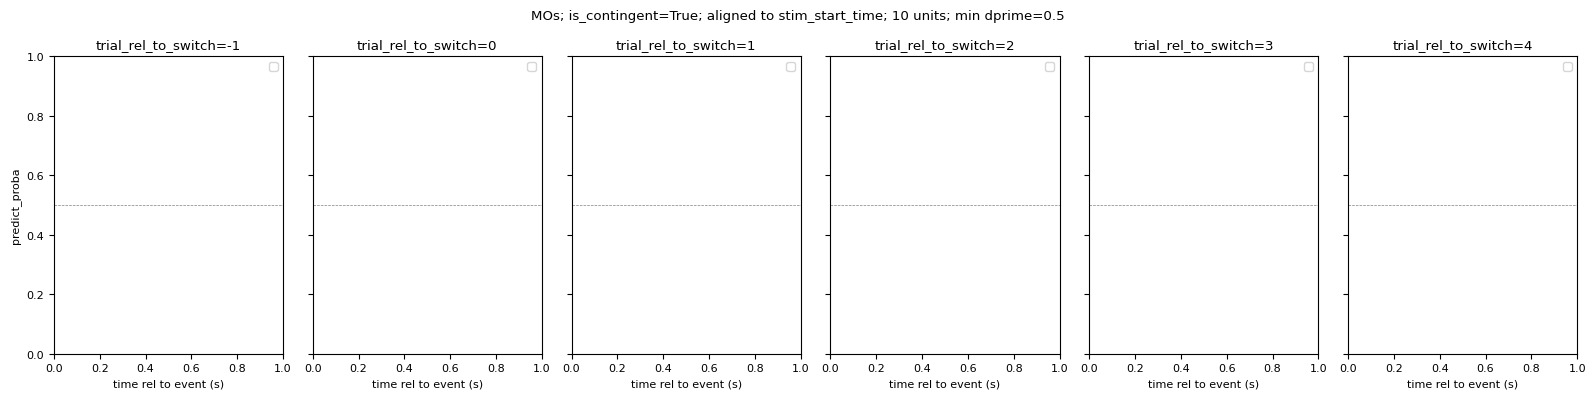

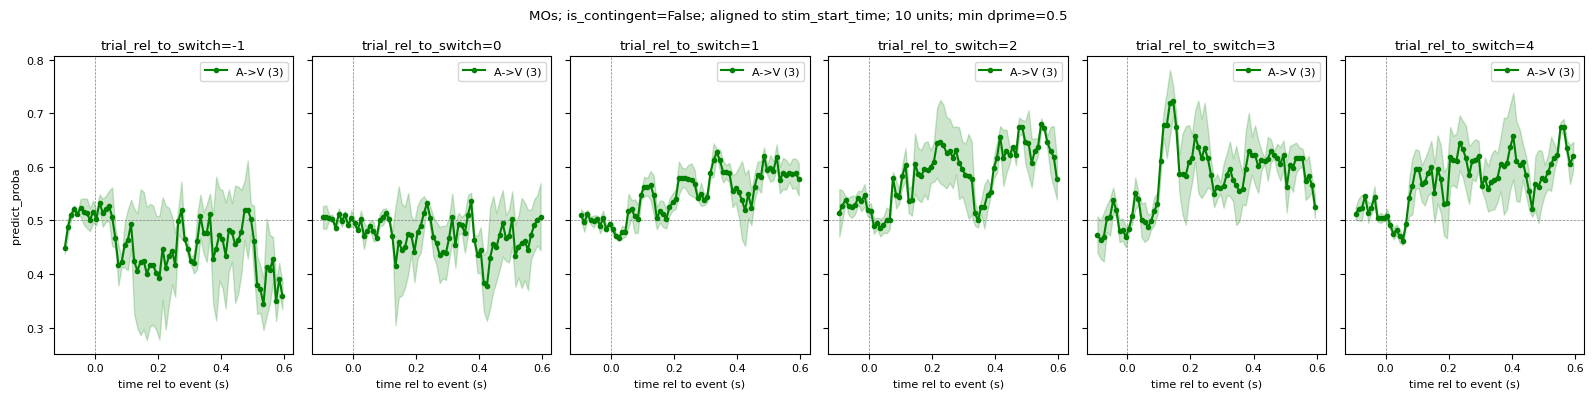

In [35]:
#plot across instruction trials
# sel_structure='ACAd'
# sel_is_contingent_switch=True
min_dprime=0.5

sel_modality='visual'

savefigs=False
savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-10-07-decode_split_by_stim_modality\switch_aligned_predict_proba\binsize_25ms"

for sel_structure in context_switch_table_df['structure'].unique():
    sel_structure='MOs'
    for sel_is_contingent_switch in [True,False]:

        fig,ax=plt.subplots(1,6,figsize=(16,4),sharex=True,sharey=True)

        for xx,sel_trial_rel_to_switch in enumerate([-1,0,1,2,3,4]):

            aud_to_vis_switches=context_switch_table_df.query(
                'structure==@sel_structure and is_vis_rewarded==True and trial_rel_to_switch==@sel_trial_rel_to_switch and \
                is_contingent_switch==@sel_is_contingent_switch and dprime_before_switch>=@min_dprime and dprime_after_switch>=@min_dprime')
            vis_to_aud_switches=context_switch_table_df.query(
                'structure==@sel_structure and is_vis_rewarded==False and trial_rel_to_switch==@sel_trial_rel_to_switch and \
                is_contingent_switch==@sel_is_contingent_switch and dprime_before_switch>=@min_dprime and dprime_after_switch>=@min_dprime')
            
            ax[xx].axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
            ax[xx].axhline(y=0.5, color='grey', linestyle='--', linewidth=0.5)
            if len(vis_to_aud_switches) > 0 and sel_modality!='visual':
                ax[xx].plot(vis_to_aud_switches['bin_centers'].iloc[0], 
                        np.nanmean(np.vstack(vis_to_aud_switches['predict_proba'].values),axis=0),
                        label=f'V->A ({len(vis_to_aud_switches)})', color='blue', marker='.')
                ax[xx].fill_between(
                    vis_to_aud_switches['bin_centers'].iloc[0], 
                    np.nanmean(np.vstack(vis_to_aud_switches['predict_proba'].values),axis=0)
                    -stats.sem(np.vstack(vis_to_aud_switches['predict_proba'].values),axis=0), 
                    np.nanmean(np.vstack(vis_to_aud_switches['predict_proba'].values),axis=0)
                    +stats.sem(np.vstack(vis_to_aud_switches['predict_proba'].values),axis=0), 
                    color='blue', alpha=0.2)
            
            if len(aud_to_vis_switches) > 0 and sel_modality!='auditory':
                ax[xx].plot(aud_to_vis_switches['bin_centers'].iloc[0], 
                        np.nanmean(np.vstack(aud_to_vis_switches['predict_proba'].values),axis=0), 
                        label=f'A->V ({len(aud_to_vis_switches)})', color='green', marker='.')
                ax[xx].fill_between(
                    aud_to_vis_switches['bin_centers'].iloc[0], 
                    np.nanmean(np.vstack(aud_to_vis_switches['predict_proba'].values),axis=0)
                    -stats.sem(np.vstack(aud_to_vis_switches['predict_proba'].values),axis=0), 
                    np.nanmean(np.vstack(aud_to_vis_switches['predict_proba'].values),axis=0)
                    +stats.sem(np.vstack(aud_to_vis_switches['predict_proba'].values),axis=0), 
                    color='green', alpha=0.2)

            # ax.set_ylim(0.2,0.8)
            ax[xx].set_xlabel('time rel to event (s)')
            if xx==0:
                ax[xx].set_ylabel('predict_proba')
            ax[xx].legend()
            ax[xx].set_title(f"trial_rel_to_switch={sel_trial_rel_to_switch}")
        fig.suptitle(f"{sel_structure}; is_contingent={sel_is_contingent_switch}; aligned to {sel_time_aligned_to}; {sel_unit_subsample_size} units; min dprime={min_dprime}")
        fig.tight_layout()

        if sel_is_contingent_switch:
            sel_is_contingent_str='contingent'
        else:
            sel_is_contingent_str='noncontingent'
        if savefigs:
            fig.savefig(os.path.join(savepath,f"{sel_structure.replace('/','-')}_{sel_is_contingent_str}_{sel_modality}.png"), dpi=300)
            plt.close(fig)


    break


In [ ]:
#plot example structure showing all sessions

#plot across instruction trials
# sel_structure='ACAd'
# sel_is_contingent_switch=True
min_dprime=0.5

sel_modality='auditory'

sel_trial_rel_to_switch=0
sel_structure='MOs'
sel_is_contingent_switch = False

savefigs=False
savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-10-07-decode_split_by_stim_modality\switch_aligned_predict_proba"


fig,ax=plt.subplots(1,1,figsize=(4,4),sharex=True,sharey=True)

aud_to_vis_switches=context_switch_table_df.query(
    'structure==@sel_structure and is_vis_rewarded==True and trial_rel_to_switch==@sel_trial_rel_to_switch and \
    is_contingent_switch==@sel_is_contingent_switch and dprime_before_switch>=@min_dprime and dprime_after_switch>=@min_dprime')
vis_to_aud_switches=context_switch_table_df.query(
    'structure==@sel_structure and is_vis_rewarded==False and trial_rel_to_switch==@sel_trial_rel_to_switch and \
    is_contingent_switch==@sel_is_contingent_switch and dprime_before_switch>=@min_dprime and dprime_after_switch>=@min_dprime')

ax.axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.5)
if len(vis_to_aud_switches) > 0 and sel_modality!='visual':
    ax.plot(vis_to_aud_switches['bin_centers'].iloc[0], 
            np.vstack(vis_to_aud_switches['predict_proba'].values).T,
            color='grey', linewidth=0.25, alpha=0.2)
    ax.plot(vis_to_aud_switches['bin_centers'].iloc[0], 
            np.nanmean(np.vstack(vis_to_aud_switches['predict_proba'].values),axis=0),
            label=f'V->A ({len(vis_to_aud_switches)})', color='black', marker='.')


if len(aud_to_vis_switches) > 0 and sel_modality!='auditory':
    ax.plot(aud_to_vis_switches['bin_centers'].iloc[0], 
            np.vstack(aud_to_vis_switches['predict_proba'].values).T,
            color='grey', linewidth=0.25, alpha=0.2)
    ax.plot(aud_to_vis_switches['bin_centers'].iloc[0], 
            np.nanmean(np.vstack(aud_to_vis_switches['predict_proba'].values),axis=0), 
            label=f'A->V ({len(aud_to_vis_switches)})', color='black', marker='.')
    

# ax.set_ylim(0.2,0.8)
ax.set_xlabel('time rel to event (s)')
if xx==0:
    ax.set_ylabel('predict_proba')
ax.legend()
ax.set_title(f"trial_rel_to_switch={sel_trial_rel_to_switch}")
fig.suptitle(f"{sel_structure}; is_contingent={sel_is_contingent_switch};\n{sel_unit_subsample_size} units; min dprime={min_dprime}")
fig.tight_layout()

if sel_is_contingent_switch:
    sel_is_contingent_str='contingent'
else:
    sel_is_contingent_str='noncontingent'
if savefigs:
    fig.savefig(os.path.join(savepath,f"example_{sel_structure.replace('/','-')}_{sel_is_contingent_str}_{sel_modality}.png"), dpi=300)
    plt.close(fig)



In [ ]:
#compare multiple structures

min_dprime=0.5

sel_modality='auditory'

sel_trial_rel_to_switch=0
sel_structures=['ACAd','MOs','MRN','CP','SCm']
# sel_structures=['FRP','AId','ORBl','CP','SCm','GPe','SNr']
sel_is_contingent_switch = False

savefigs=False
savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-10-07-decode_split_by_stim_modality\switch_aligned_predict_proba\binsize_25ms"


fig,ax=plt.subplots(1,1,figsize=(4,4),sharex=True,sharey=True)

for sel_structure in sel_structures:

    aud_to_vis_switches=context_switch_table_df.query(
        'structure==@sel_structure and is_vis_rewarded==True and trial_rel_to_switch==@sel_trial_rel_to_switch and \
        is_contingent_switch==@sel_is_contingent_switch and dprime_before_switch>=@min_dprime and dprime_after_switch>=@min_dprime')
    vis_to_aud_switches=context_switch_table_df.query(
        'structure==@sel_structure and is_vis_rewarded==False and trial_rel_to_switch==@sel_trial_rel_to_switch and \
        is_contingent_switch==@sel_is_contingent_switch and dprime_before_switch>=@min_dprime and dprime_after_switch>=@min_dprime')

    ax.axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
    ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.5)
    if len(vis_to_aud_switches) > 0 and sel_modality!='visual':
        ax.plot(vis_to_aud_switches['bin_centers'].iloc[0], 
                np.nanmean(np.vstack(vis_to_aud_switches['predict_proba'].values),axis=0),
                label=f'{sel_structure} ({len(vis_to_aud_switches)})', marker='.')
        ax.fill_between(
            vis_to_aud_switches['bin_centers'].iloc[0], 
            np.nanmean(np.vstack(vis_to_aud_switches['predict_proba'].values),axis=0)
            -stats.sem(np.vstack(vis_to_aud_switches['predict_proba'].values),axis=0), 
            np.nanmean(np.vstack(vis_to_aud_switches['predict_proba'].values),axis=0)
            +stats.sem(np.vstack(vis_to_aud_switches['predict_proba'].values),axis=0), 
            alpha=0.2)
    
    if len(aud_to_vis_switches) > 0 and sel_modality!='auditory':
        ax.plot(aud_to_vis_switches['bin_centers'].iloc[0], 
                np.nanmean(np.vstack(aud_to_vis_switches['predict_proba'].values),axis=0), 
                label=f'{sel_structure} ({len(aud_to_vis_switches)})', marker='.')
        ax.fill_between(
            aud_to_vis_switches['bin_centers'].iloc[0], 
            np.nanmean(np.vstack(aud_to_vis_switches['predict_proba'].values),axis=0)
            -stats.sem(np.vstack(aud_to_vis_switches['predict_proba'].values),axis=0), 
            np.nanmean(np.vstack(aud_to_vis_switches['predict_proba'].values),axis=0)
            +stats.sem(np.vstack(aud_to_vis_switches['predict_proba'].values),axis=0), 
            alpha=0.2)
    

# ax.set_ylim(0.2,0.8)
ax.set_xlabel('time rel to event (s)')
# if xx==0:
ax.set_ylabel('predict_proba')
ax.legend()
ax.set_title(f"trial_rel_to_switch={sel_trial_rel_to_switch}; is_contingent={sel_is_contingent_switch};\n{sel_unit_subsample_size} units; min dprime={min_dprime}")
ax.set_xlim(0.5,1.5)
# fig.suptitle(f"trial_rel_to_switch={sel_trial_rel_to_switch}; is_contingent={sel_is_contingent_switch};\n{sel_unit_subsample_size} units; min dprime={min_dprime}")
fig.tight_layout()

# if sel_is_contingent_switch:
#     sel_is_contingent_str='contingent'
# else:
#     sel_is_contingent_str='noncontingent'
# if savefigs:
#     fig.savefig(os.path.join(savepath,f"example_{sel_structure.replace('/','-')}_{sel_is_contingent_str}_{sel_modality}.png"), dpi=300)
#     plt.close(fig)



In [ ]:
sel_session='742903_2024-10-22'
context_switch_table_df.query('session_id==@sel_session')['structure'].unique()

In [ ]:
# compare simultaneuously recorded structures within a session

sel_session='742903_2024-10-22'
sel_structure_1='ORBl'
sel_structure_2='PL'
sel_unit_subsample_size='all'
sel_time_aligned_to='stim_start_time'
sel_trial_rel_to_switch=0
sel_is_contingent_switch=False

struct1_table=context_switch_table_df.query(
    'session_id==@sel_session and structure==@sel_structure_1 and \
    trial_rel_to_switch==@sel_trial_rel_to_switch and is_contingent_switch==@sel_is_contingent_switch'
    )

struct2_table=context_switch_table_df.query(
    'session_id==@sel_session and structure==@sel_structure_2 and \
    trial_rel_to_switch==@sel_trial_rel_to_switch and is_contingent_switch==@sel_is_contingent_switch'
    )

for rr in range(len(struct1_table)):
    fig,ax=plt.subplots(1,1,figsize=(4,4))

    ax.axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
    ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.5)

    ax.plot(struct1_table['bin_centers'].iloc[rr], 
            struct1_table['predict_proba'].iloc[rr], 
            label=f'{sel_structure_1}', color='blue', marker='.')
    
    ax.plot(struct2_table['bin_centers'].iloc[rr], 
            struct2_table['predict_proba'].iloc[rr], 
            label=f'{sel_structure_2}', color='green', marker='.')

    ax.set_xlabel('time rel to event (s)')
    ax.set_ylabel('predict_proba')
    ax.legend()
    ax.set_title(f"{sel_session}; trial_rel_to_switch={sel_trial_rel_to_switch}; is_contingent={sel_is_contingent_switch};\n{sel_unit_subsample_size} units")
    fig.tight_layout()

struct1_avg=np.nanmean(np.vstack(struct1_table['predict_proba'].values),axis=0)
struct2_avg=np.nanmean(np.vstack(struct2_table['predict_proba'].values),axis=0)

# fig,ax=plt.subplots(1,1,figsize=(4,4))
# ax.axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
# ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.5)
# ax.plot(struct1_table['bin_centers'].iloc[0], 
#         struct1_avg, 
#         label=f'{sel_structure_1}', color='blue', marker='.')
# ax.plot(struct2_table['bin_centers'].iloc[0], 
#         struct2_avg, 
#         label=f'{sel_structure_2}', color='green', marker='.')

In [ ]:
#find where each average reaches at least 0.6
struct1_thresh=0.6
struct2_thresh=0.6
struct1_reach_thresh=np.where(struct1_avg>=struct1_thresh)[0][0]
struct2_reach_thresh=np.where(struct2_avg>=struct2_thresh)[0][0]
bin_centers=struct1_table['bin_centers'].iloc[0]
delta_t=bin_centers[struct1_reach_thresh]-bin_centers[struct2_reach_thresh]
#plot point and delta t
fig,ax=plt.subplots(1,1,figsize=(4,4))
ax.axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.5)
ax.plot(bin_centers,struct1_avg, 
        label=f'{sel_structure_1}', color='blue', marker='.')
ax.plot(bin_centers,struct2_avg, 
        label=f'{sel_structure_2}', color='green', marker='.')

ax.plot(bin_centers[struct1_reach_thresh], struct1_avg[struct1_reach_thresh], '*', color='blue', markersize=10, label=f'{sel_structure_1} >= {struct1_thresh}')
ax.plot(bin_centers[struct2_reach_thresh], struct2_avg[struct2_reach_thresh], '*', color='green', markersize=10, label=f'{sel_structure_2} >= {struct2_thresh}')

ax.set_title(f'Δt={delta_t:.3f}s')
ax.set_xlabel('time rel to event (s)')
ax.set_ylabel('predict_proba')
ax.legend()

In [ ]:
#find switch by requiring value to be larger than all pre-switch values, and at least 0.6

sel_session='742903_2024-10-22'
sel_structure_1='CP'
sel_structure_2='ORBm'
sel_unit_subsample_size='all'
sel_time_aligned_to='stim_start_time'
sel_trial_rel_to_switch=0
sel_is_contingent_switch=False

struct1_table=context_switch_table_df.query(
    'session_id==@sel_session and structure==@sel_structure_1 and \
    trial_rel_to_switch==@sel_trial_rel_to_switch and is_contingent_switch==@sel_is_contingent_switch'
    )

struct2_table=context_switch_table_df.query(
    'session_id==@sel_session and structure==@sel_structure_2 and \
    trial_rel_to_switch==@sel_trial_rel_to_switch and is_contingent_switch==@sel_is_contingent_switch'
    )

struct1_pre_values=np.vstack(struct1_table['predict_proba'].values)[:,bin_centers<=1.0].flatten()
struct2_pre_values=np.vstack(struct2_table['predict_proba'].values)[:,bin_centers<=1.0].flatten()

bin_centers=struct1_table['bin_centers'].iloc[0]

for sw in range(len(struct1_table)):
    
    struct1_switch_ind=np.where((struct1_table['predict_proba'].values[sw]>np.max(struct1_pre_values))&
                                 (struct1_table['predict_proba'].values[sw]>=0.6))[0]
    struct2_switch_ind=np.where((struct2_table['predict_proba'].values[sw]>np.max(struct2_pre_values))&
                                 (struct2_table['predict_proba'].values[sw]>=0.6))[0]
    # struct1_switch_ind=np.where((struct1_table['predict_proba'].values[sw]>np.max(struct1_pre_values)))[0]
    # struct2_switch_ind=np.where((struct2_table['predict_proba'].values[sw]>np.max(struct2_pre_values)))[0]
    
    if len(struct1_switch_ind)==0 or len(struct2_switch_ind)==0:
        print(f"switch {sw}: no switch time found")
        continue
    else:
        struct1_switch_ind=struct1_switch_ind[0]
        struct2_switch_ind=struct2_switch_ind[0]

    delta_t_switch=bin_centers[struct1_switch_ind]-bin_centers[struct2_switch_ind]
    print(f"switch {sw}: Δt={delta_t_switch:.3f}s")

    fig,ax=plt.subplots(1,1,figsize=(4,4))

    ax.axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
    ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.5)

    ax.plot(struct1_table['bin_centers'].iloc[sw], 
            struct1_table['predict_proba'].iloc[sw], 
            label=f'{sel_structure_1}', color='blue', marker='.')
    
    ax.plot(bin_centers[struct1_switch_ind], struct1_table['predict_proba'].values[sw][struct1_switch_ind], 
            '*', color='blue', markersize=10, label=f'{sel_structure_1} switch')
    
    ax.plot(struct2_table['bin_centers'].iloc[sw], 
            struct2_table['predict_proba'].iloc[sw], 
            label=f'{sel_structure_2}', color='green', marker='.')
    
    ax.plot(bin_centers[struct2_switch_ind], struct2_table['predict_proba'].values[sw][struct2_switch_ind], 
            '*', color='green', markersize=10, label=f'{sel_structure_2} switch')
    
    ax.set_xlabel('time rel to event (s)')
    ax.set_ylabel('predict_proba')
    ax.legend()
    ax.set_title(f"{sel_session}; Δt={delta_t_switch:.3f}s")
    fig.tight_layout()



In [ ]:
#find time lag between all structures


In [ ]:
# context_switch_table_df

In [ ]:
#find time lag between all pairs of structures
sel_trial_rel_to_switch = 0
sel_is_contingent_switch = False
sel_unit_subsample_size = 20
sel_time_aligned_to = 'stim_start_time'
# dprime_threshold=0.5

time_lag_table={
    'session_id':[],
    'structure_1':[],
    'structure_2':[],
    'switch_index':[],
    'unit_subsample_size':[],
    'time_aligned_to':[],
    'trial_rel_to_switch':[],
    'is_contingent_switch':[],
    'struct1_switch_time':[],
    'struct2_switch_time':[],
    #add dprime before/after
    'dprime_before':[],
    'dprime_after':[],
    'delta_t':[],
}
for sel_session in context_switch_table_df['session_id'].unique():
    session_structures=context_switch_table_df.query('session_id==@sel_session')['structure'].unique()
    for ss1 in range(len(session_structures)):
        for ss2 in range(len(session_structures)):
            if ss1==ss2:
                continue
            
            sel_structure_1=session_structures[ss1]
            sel_structure_2=session_structures[ss2]
                
            struct1_table=context_switch_table_df.query(
                'session_id==@sel_session and structure==@sel_structure_1 and unit_subsample_size==@sel_unit_subsample_size and \
                time_aligned_to==@sel_time_aligned_to and trial_rel_to_switch==@sel_trial_rel_to_switch and \
                is_contingent_switch==@sel_is_contingent_switch'
                )

            struct2_table=context_switch_table_df.query(
                'session_id==@sel_session and structure==@sel_structure_2 and unit_subsample_size==@sel_unit_subsample_size and \
                time_aligned_to==@sel_time_aligned_to and trial_rel_to_switch==@sel_trial_rel_to_switch and \
                is_contingent_switch==@sel_is_contingent_switch'
                )
            
            if len(struct1_table)==0 or len(struct2_table)==0:
                continue
            
            struct1_pre_values=np.vstack(struct1_table['predict_proba'].values)[:,bin_centers<=1.0].flatten()
            struct2_pre_values=np.vstack(struct2_table['predict_proba'].values)[:,bin_centers<=1.0].flatten()

            bin_centers=struct1_table['bin_centers'].iloc[0]

            for sw in range(len(struct1_table)):
                is_vis_rewarded=struct1_table['is_vis_rewarded'].iloc[sw]

                dprime_before=struct1_table['dprime_before_switch'].iloc[sw]
                dprime_after=struct1_table['dprime_after_switch'].iloc[sw]
                
                if is_vis_rewarded:
                    struct1_switch_ind=np.where((struct1_table['predict_proba'].values[sw]>np.max(struct1_pre_values))&
                                             (struct1_table['predict_proba'].values[sw]>=0.6))[0]
                    struct2_switch_ind=np.where((struct2_table['predict_proba'].values[sw]>np.max(struct2_pre_values))&
                                                (struct2_table['predict_proba'].values[sw]>=0.6))[0]
                    # struct1_switch_ind=np.where((struct1_table['predict_proba'].values[sw]>np.max(struct1_pre_values)))[0]
                    # struct2_switch_ind=np.where((struct2_table['predict_proba'].values[sw]>np.max(struct2_pre_values)))[0]
                    if (np.mean(struct1_pre_values>0.5) > 0.5) or (np.mean(struct2_pre_values>0.5) > 0.5):
                        #skip if pre-switch values are too high
                        continue
                else:
                    struct1_switch_ind=np.where((struct1_table['predict_proba'].values[sw]<np.max(struct1_pre_values))&
                                             (struct1_table['predict_proba'].values[sw]<=0.4))[0]
                    struct2_switch_ind=np.where((struct2_table['predict_proba'].values[sw]<np.max(struct2_pre_values))&
                                                (struct2_table['predict_proba'].values[sw]<=0.4))[0]
                    # struct1_switch_ind=np.where((struct1_table['predict_proba'].values[sw]>np.max(struct1_pre_values)))[0]
                    # struct2_switch_ind=np.where((struct2_table['predict_proba'].values[sw]>np.max(struct2_pre_values)))[0]
                    if (np.mean(struct1_pre_values<0.5) > 0.5) or (np.mean(struct2_pre_values<0.5) > 0.5):
                        #skip if pre-switch values are too high
                        continue

                if len(struct1_switch_ind)==0 or len(struct2_switch_ind)==0:
                    # print(f"switch {sw}: no switch time found")
                    delta_t=np.nan
                    if len(struct1_switch_ind)>0:
                        struct1_switch_ind=struct1_switch_ind[0]
                        struct1_switch_time=bin_centers[struct1_switch_ind]
                    else:
                        struct1_switch_time=np.nan
                    if len(struct2_switch_ind)>0:
                        struct2_switch_ind=struct2_switch_ind[0]
                        struct2_switch_time=bin_centers[struct2_switch_ind]
                    else:
                        struct2_switch_time=np.nan
                else:
                    struct1_switch_ind=struct1_switch_ind[0]
                    struct2_switch_ind=struct2_switch_ind[0]
                    struct1_switch_time=bin_centers[struct1_switch_ind]
                    struct2_switch_time=bin_centers[struct2_switch_ind]
                    delta_t=bin_centers[struct1_switch_ind]-bin_centers[struct2_switch_ind]


            # struct1_avg=np.nanmean(np.vstack(struct1_table['predict_proba'].values),axis=0)
            # struct2_avg=np.nanmean(np.vstack(struct2_table['predict_proba'].values),axis=0)

            # #find where each average reaches at least 0.6
            # struct1_thresh=0.6
            # struct2_thresh=0.6
            # try:
            #     struct1_reach_thresh=np.where(struct1_avg>=struct1_thresh)[0][0]
            #     struct2_reach_thresh=np.where(struct2_avg>=struct2_thresh)[0][0]
            # except IndexError:
            #     #one of the structures never reaches threshold
            #     continue
            # bin_centers=struct1_table['bin_centers'].iloc[0]
            # delta_t=bin_centers[struct1_reach_thresh]-bin_centers[struct2_reach_thresh]

                time_lag_table['session_id'].append(sel_session)
                time_lag_table['structure_1'].append(sel_structure_1)
                time_lag_table['structure_2'].append(sel_structure_2)
                time_lag_table['switch_index'].append(sw)
                time_lag_table['unit_subsample_size'].append(sel_unit_subsample_size)
                time_lag_table['time_aligned_to'].append(sel_time_aligned_to)
                time_lag_table['trial_rel_to_switch'].append(sel_trial_rel_to_switch)
                time_lag_table['is_contingent_switch'].append(sel_is_contingent_switch)
                time_lag_table['struct1_switch_time'].append(struct1_switch_time)
                time_lag_table['struct2_switch_time'].append(struct2_switch_time)
                time_lag_table['dprime_before'].append(dprime_before)
                time_lag_table['dprime_after'].append(dprime_after)
                time_lag_table['delta_t'].append(delta_t)
    # break

time_lag_table_df=pd.DataFrame(time_lag_table)

In [ ]:
# (time_lag_table_df[['structure_1','structure_2']].value_counts()['MOs']>=3).sum()

In [ ]:
dprime_threshold=0.5
#make heatmap of average time lags between structures

#build time lag matrix from this dataframe
unique_structures=time_lag_table_df['structure_1'].unique()

incl_structures=[]
for st in unique_structures:
    if (time_lag_table_df[['structure_1','structure_2']].value_counts()[st]>=3).sum()>=25:
        incl_structures.append(st)

incl_structures=np.sort(incl_structures)

time_lag_matrix=np.full((len(incl_structures), len(incl_structures)), np.nan)
for rr, sel_structure_0 in enumerate(incl_structures):
    for cc, sel_structure_1 in enumerate(incl_structures):
        if sel_structure_0==sel_structure_1:
            time_lag_matrix[rr,cc]=np.nan
        else:
            temp_df=time_lag_table_df.query(f'structure_1=="{sel_structure_0}" and structure_2=="{sel_structure_1}" and \
                                            dprime_before>=@dprime_threshold and dprime_after>=@dprime_threshold and \
                                            ~delta_t.isna()')
            #only save if at least 3 switches
            if len(temp_df)>=3:
                time_lag_matrix[rr,cc]=np.nanmean(temp_df['delta_t'])

In [ ]:
time_lag_table_df.query('structure_1=="MOs"')

In [ ]:
masked_array = np.ma.array(time_lag_matrix, mask=np.isnan(time_lag_matrix))
cmap = matplotlib.cm.bwr
cmap.set_bad('grey',0.5)

fig,ax=plt.subplots(1,1,figsize=(8,8))
im=ax.imshow(masked_array, cmap=cmap,vmin=-1,vmax=1)
ax.set_xticks(np.arange(len(incl_structures)))
ax.set_yticks(np.arange(len(incl_structures)))
ax.set_xticklabels(incl_structures, rotation=90, ha='right')
ax.set_yticklabels(incl_structures)

fig.colorbar(im, ax=ax, label='Average Δt (s)')


In [ ]:
#sort by average time lag across rows
masked_array_col_mean = np.nanmean(masked_array, axis=0)
sorted_col_indices = np.argsort(masked_array_col_mean)
masked_array_row_mean = np.nanmean(masked_array, axis=1)
sorted_row_indices = np.argsort(masked_array_row_mean)
sorted_time_lag_matrix = masked_array[sorted_row_indices, :][:, :]
fig,ax=plt.subplots(1,1,figsize=(8,8))
im=ax.imshow(sorted_time_lag_matrix, cmap=cmap,vmin=-1,vmax=1)
ax.set_xticks(np.arange(len(incl_structures)))
ax.set_yticks(np.arange(len(incl_structures)))
ax.set_xticklabels(incl_structures, rotation=90, ha='right')
ax.set_yticklabels(incl_structures[sorted_row_indices])

fig.colorbar(im, ax=ax, label='Average Δt (s)')


In [ ]:
#cross-correlation of the two average traces

#normalize averages between 0 and 1
# struct1_avg_norm=(struct1_avg - np.min(struct1_avg)) / (np.max(struct1_avg) - np.min(struct1_avg))
# struct2_avg_norm=(struct2_avg - np.min(struct2_avg)) / (np.max(struct2_avg) - np.min(struct2_avg))

# struct1_avg_norm=(struct1_avg - np.mean(struct1_avg)) 
# struct2_avg_norm=(struct2_avg - np.mean(struct2_avg))

struct1_avg_norm=struct1_avg
struct2_avg_norm=struct2_avg

fig,ax=plt.subplots(1,1,figsize=(4,4))
ax.axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
ax.axhline(y=0, color='grey', linestyle='--', linewidth=0.5)
ax.plot(struct1_table['bin_centers'].iloc[0], 
        struct1_avg_norm, 
        label=f'{sel_structure_1}', color='blue', marker='.')
ax.plot(struct2_table['bin_centers'].iloc[0], 
        struct2_avg_norm,
        label=f'{sel_structure_2}', color='green', marker='.')

corr=np.correlate(struct1_avg_norm, struct2_avg_norm, mode='same')
# lags=np.arange(-len(struct1_avg_norm)+1, len(struct1_avg_norm))
lags=np.arange(-len(struct1_avg_norm)//2, len(struct1_avg_norm)//2)
maxlagind=np.argmax(corr)

fig,ax=plt.subplots(1,1,figsize=(4,4))
ax.plot(lags, corr)
ax.plot(lags[maxlagind], corr[maxlagind], 'ro')
ax.set_title(f"max corr at lag {lags[maxlagind]} bins ({lags[maxlagind]*0.025:.3f} s)")

In [ ]:
corr

In [ ]:
min_dprime=0.5

structure_list=context_switch_table_df['structure'].unique()

structure_average_predict_proba={
    'structure':[],
    'predict_proba':[],
    'trial_rel_to_switch':[],
    'is_contingent_switch':[],
    'is_vis_rewarded':[],
    'n_switches':[],
}

for sel_structure in structure_list:
    for sel_is_vis_rewarded in [True,False]:
        for sel_is_contingent_switch in [True,False]:
            for xx,sel_trial_rel_to_switch in enumerate([-1,0,1,2,3,4]):
                switches=context_switch_table_df.query(
                    'structure==@sel_structure and is_vis_rewarded==@sel_is_vis_rewarded and trial_rel_to_switch==@sel_trial_rel_to_switch and \
                    is_contingent_switch==@sel_is_contingent_switch and dprime_before_switch>=@min_dprime and dprime_after_switch>=@min_dprime')
                
                if len(switches) > 0:
                    #get the predict proba for the structure
                    structure_predict_proba=np.vstack(switches['predict_proba'].values)

                    #average across trials
                    structure_average_predict_proba['structure'].append(sel_structure)
                    structure_average_predict_proba['trial_rel_to_switch'].append(sel_trial_rel_to_switch)
                    structure_average_predict_proba['is_contingent_switch'].append(sel_is_contingent_switch)
                    structure_average_predict_proba['is_vis_rewarded'].append(sel_is_vis_rewarded)

                    #stack the predict proba
                    structure_predict_proba=np.vstack(structure_predict_proba)

                    #average across trials
                    structure_average_predict_proba['predict_proba'].append(np.nanmean(structure_predict_proba, axis=0))
                    structure_average_predict_proba['n_switches'].append(len(switches))
                
                
structure_average_predict_proba_df=pd.DataFrame(structure_average_predict_proba)

In [ ]:
trial_index.shape
predict_proba_stack.shape
session_trials.shape

In [ ]:
# context_switch_table_df.query(
#     'structure==@sel_structure and is_vis_rewarded==@is_vis_rewarded and trial_rel_to_switch==0 and \
#     is_contingent_switch==True and dprime_before_switch>=@min_dprime and dprime_after_switch>=@min_dprime')
# context_switch_table_df.query('is_contingent_switch==True')

In [ ]:
structure_average_predict_proba_df['structure'].unique()

In [ ]:
is_vis_rewarded=False
is_contingent_switch=False
min_n_switches=0
# exclude_from_plot=['LD','MD','MGd','SGN','VPM']
exclude_from_plot=['VPM']

structure_result_list=structure_average_predict_proba_df.query('n_switches>=@min_n_switches and structure not in @exclude_from_plot').sort_values(by='structure')['structure'].unique()

trials_to_plot=[-1,0,1,2,3,4]

fig,ax=plt.subplots(1,len(trials_to_plot),figsize=(12,8),sharex=True,sharey=True)
for xx,sel_trial_rel_to_switch in enumerate(trials_to_plot):
    
    sel_switches=structure_average_predict_proba_df.query(
        'trial_rel_to_switch==@sel_trial_rel_to_switch and \
        is_vis_rewarded==@is_vis_rewarded and \
        is_contingent_switch==@is_contingent_switch')# and \
        # n_switches>=@min_n_switches').sort_values(by='structure')
    
    ax[xx].set_title(f"trial_rel_to_switch={sel_trial_rel_to_switch}")
    if len(sel_switches) == 0:
        continue

    heatmap_array=np.full((len(structure_result_list), len(sel_switches['predict_proba'].iloc[0])), np.nan)

    for ss,structure_str in enumerate(structure_result_list):
        if structure_str in sel_switches['structure'].values:
            heatmap_array[ss,:]=sel_switches.query('structure==@structure_str')['predict_proba'].values[0]
        else:
            heatmap_array[ss,:]=np.nan
            
    im=ax[xx].imshow(heatmap_array, aspect='auto', interpolation='none', cmap='bwr', vmin=0.15, vmax=0.85, extent=[-1.5, 5.5, heatmap_array.shape[0]-0.5,-0.5])
    ax[xx].axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
    ax[xx].set_xlabel('time rel to event (s)')
    ax[xx].set_yticks(np.arange(len(structure_result_list)))
    ax[xx].set_yticklabels(structure_result_list, ha='right')

fig.suptitle(f"is_vis_rewarded={is_vis_rewarded}; is_contingent_switch={is_contingent_switch}; time_aligned_to={sel_time_aligned_to}")
fig.tight_layout()

In [ ]:
sel_switches

In [ ]:
# distribution of switch-provoked changes in predict_proba

sel_structure='PL'
sel_trial_rel_to_switch=0
# sel_is_vis_rewarded=True
# sel_is_contingent_switch=False
# min_n_switches=12
min_dprime=0.5

xbins=np.arange(-1.0,1.0+.1,0.005)
fig,ax=plt.subplots(1,1,figsize=(6,4))
ax.axvline(0, color='k', linestyle='--', linewidth=0.5)

context_label=['V->A','A->V']
contingent_label=['noncontingent','contingent']

for sel_is_vis_rewarded in [False,True]:
    for sel_is_contingent_switch in [False,True]:
        
        label_str= f"{context_label[int(sel_is_vis_rewarded)]} {contingent_label[int(sel_is_contingent_switch)]}"

        switches=context_switch_table_df.query(
            'structure==@sel_structure and is_vis_rewarded==@sel_is_vis_rewarded and trial_rel_to_switch==@sel_trial_rel_to_switch and \
            is_contingent_switch==@sel_is_contingent_switch and dprime_before_switch>=@min_dprime and dprime_after_switch>=@min_dprime')

        ax.hist(switches['delta_predict_proba_2_bins'],bins=xbins,label=label_str,cumulative=True,histtype='step',density=True)

ax.legend()
ax.set_xlabel('change in predict_proba (2 bins)')
ax.set_ylabel('cumulative density')
ax.set_title(f"{sel_structure}; trial_rel_to_switch={sel_trial_rel_to_switch}; min_dprime={min_dprime}")


In [ ]:
switches['delta_predict_proba_2_bins'].mean()

In [ ]:
#get average and sem delta predict proba per structure, make new dataframe

sel_trial_rel_to_switch=0
min_dprime=0.5
context_labels=['aud','vis']
contingent_labels=['non_contingent','contingent']

delta_predict_proba_by_structure={
    'structure':[],

    'delta_2_vis_contingent_mean':[],
    'delta_3_vis_contingent_mean':[],
    'delta_2_vis_contingent_sem':[],
    'delta_3_vis_contingent_sem':[],
    'n_switches_vis_contingent':[],

    'delta_2_vis_non_contingent_mean':[],
    'delta_3_vis_non_contingent_mean':[],
    'delta_2_vis_non_contingent_sem':[],
    'delta_3_vis_non_contingent_sem':[],
    'n_switches_vis_non_contingent':[],

    'delta_2_aud_contingent_mean':[],
    'delta_3_aud_contingent_mean':[],
    'delta_2_aud_contingent_sem':[],
    'delta_3_aud_contingent_sem':[],
    'n_switches_aud_contingent':[],

    'delta_2_aud_non_contingent_mean':[],
    'delta_3_aud_non_contingent_mean':[],
    'delta_2_aud_non_contingent_sem':[],
    'delta_3_aud_non_contingent_sem':[],
    'n_switches_aud_non_contingent':[],
}

for sel_structure in context_switch_table_df['structure'].unique():
    delta_predict_proba_by_structure['structure'].append(sel_structure)
    for sel_is_vis_rewarded in [False,True]:
        for sel_is_contingent_switch in [False,True]:
            
            switches=context_switch_table_df.query(
                'structure==@sel_structure and is_vis_rewarded==@sel_is_vis_rewarded and trial_rel_to_switch==@sel_trial_rel_to_switch and \
                is_contingent_switch==@sel_is_contingent_switch and dprime_before_switch>=@min_dprime and dprime_after_switch>=@min_dprime')
            
            delta_predict_proba_by_structure[f'delta_2_{context_labels[sel_is_vis_rewarded]}_{contingent_labels[sel_is_contingent_switch]}_mean'].append(switches['delta_predict_proba_2_bins'].median())
            delta_predict_proba_by_structure[f'delta_3_{context_labels[sel_is_vis_rewarded]}_{contingent_labels[sel_is_contingent_switch]}_mean'].append(switches['delta_predict_proba_3_bins'].median())
            delta_predict_proba_by_structure[f'delta_2_{context_labels[sel_is_vis_rewarded]}_{contingent_labels[sel_is_contingent_switch]}_sem'].append(stats.sem(switches['delta_predict_proba_2_bins']))
            delta_predict_proba_by_structure[f'delta_3_{context_labels[sel_is_vis_rewarded]}_{contingent_labels[sel_is_contingent_switch]}_sem'].append(stats.sem(switches['delta_predict_proba_3_bins']))
            delta_predict_proba_by_structure[f'n_switches_{context_labels[sel_is_vis_rewarded]}_{contingent_labels[sel_is_contingent_switch]}'].append(len(switches))

delta_predict_proba_by_structure_df=pd.DataFrame(delta_predict_proba_by_structure)
delta_predict_proba_by_structure_df

In [ ]:
# label_str

In [ ]:
set_min_n_switches=10
sorted_table=delta_predict_proba_by_structure_df.query('n_switches_vis_contingent>=@set_min_n_switches and n_switches_vis_non_contingent>=@set_min_n_switches and \
                                                       n_switches_aud_contingent>=@set_min_n_switches and n_switches_aud_non_contingent>=@set_min_n_switches'
                                                       ).sort_values(by='delta_2_vis_non_contingent_mean', ascending=False)

fig,ax=plt.subplots(1,1,figsize=(14,4))
sorted_table.plot.bar(x='structure', y=['delta_2_vis_non_contingent_mean','delta_2_vis_contingent_mean','delta_2_aud_non_contingent_mean','delta_2_aud_contingent_mean'], ax=ax, legend=True)

ax.set_ylabel('change in predict proba after first switch trial')
fig.tight_layout()

In [ ]:
set_min_n_switches=10
sorted_table=delta_predict_proba_by_structure_df.query('n_switches_vis_contingent>=@set_min_n_switches and n_switches_vis_non_contingent>=@set_min_n_switches and \
                                                       n_switches_aud_contingent>=@set_min_n_switches and n_switches_aud_non_contingent>=@set_min_n_switches'
                                                       ).sort_values(by='delta_3_vis_non_contingent_mean', ascending=False)

fig,ax=plt.subplots(1,1,figsize=(14,4))
sorted_table.plot.bar(x='structure', y=['delta_3_vis_non_contingent_mean','delta_3_vis_contingent_mean','delta_3_aud_non_contingent_mean','delta_3_aud_contingent_mean'], ax=ax, legend=True)

ax.set_ylabel('change in predict proba after first switch trial')
fig.tight_layout()

In [ ]:
### TODO: same as above except filter for simultaneously recorded stuctures - maybe ACAd and MOs for example

In [ ]:
#get predict_proba for different trial types, make new table

# sel_session="664851_2023-11-13"
# sel_structure="SCm"
sel_unit_subsample_size='all'
sel_time_aligned_to='stim_start_time'

# get_trials_rel_to_switch=[-3,-2,-1,0,1,2,3,4]
all_performance=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.268/consolidated/performance.parquet').collect().to_pandas()
all_trials=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.268/consolidated/trials.parquet').collect().to_pandas()

trial_type_table={
    'session_id':[],
    'structure':[],
    'predict_proba':[],
    'bin_centers':[],
    'unit_subsample_size':[],
    'time_aligned_to':[],
    'trial_index':[],
    'is_response':[],
    'is_vis_rewarded':[],
    'stim_name':[],
    'n_trials':[],
    'session_dprime':[],
    'n_passing_vis_blocks':[],
    'n_passing_aud_blocks':[],
}

for sel_session in predict_proba_pd['session_id'].unique():
    if sel_session not in dr_session_list:
        print(f"session {sel_session} not in dr_session_list; skipping")
        continue
    
    session_performance=all_performance.query(f'session_id=="{sel_session}"')
    session_dprime=session_performance['cross_modality_dprime'].mean()
    n_passing_vis_blocks=session_performance.query('rewarded_modality=="vis" and cross_modality_dprime>1').shape[0]
    n_passing_aud_blocks=session_performance.query('rewarded_modality=="aud" and cross_modality_dprime>1').shape[0]
    session_trials=all_trials.query(f'session_id=="{sel_session}"')

    for sel_structure in predict_proba_pd.query('session_id==@sel_session')['structure'].unique():

        #get session-structure results
        example_area_results=get_session_structure_results(predict_proba_pd, sel_session, sel_structure, sel_unit_subsample_size, sel_time_aligned_to)

        predict_proba_stack=np.vstack(example_area_results['predict_proba'].values).T

        #these are the indices of trials with data (i.e. for response aligned trials)
        trial_index=example_area_results['trial_index'].iloc[0]

        if trial_index.shape[0]!=predict_proba_stack.shape[0]:
            print('warning! trial_index does not match predict_proba_stack, just taking the first X trials')
            trial_index=trial_index[:predict_proba_stack.shape[0]]

        #loop through type of trials?
        for is_vis_rewarded in [True,False]:

            for stim_name in session_trials['stim_name'].unique():

                for is_response in [True,False]:

                    #get the trial indices for this trial type
                    trial_type_indices=session_trials.query(
                        'is_reward_scheduled==False and is_vis_rewarded==@is_vis_rewarded and \
                        stim_name==@stim_name and is_response==@is_response'
                        )['trial_index'].values

                    #get the subset of these trial indices available in the data
                    available_trial_type_indices=np.where(np.isin(trial_index, trial_type_indices))[0]

                    #get the number of trials
                    n_trials=len(available_trial_type_indices)

                    if n_trials == 0:
                        predict_proba_values=np.nan*np.ones(predict_proba_stack.shape[1])
                    else:
                        #get the average preidict_proba for these trials
                        predict_proba_values=np.nanmean(predict_proba_stack[available_trial_type_indices,:], axis=0)

                    trial_type_table['session_id'].append(sel_session)
                    trial_type_table['structure'].append(sel_structure)
                    trial_type_table['predict_proba'].append(predict_proba_values)
                    trial_type_table['bin_centers'].append(example_area_results['bin_center'].values)
                    trial_type_table['unit_subsample_size'].append(sel_unit_subsample_size)
                    trial_type_table['time_aligned_to'].append(sel_time_aligned_to)
                    trial_type_table['trial_index'].append(available_trial_type_indices)
                    trial_type_table['is_response'].append(is_response)
                    trial_type_table['is_vis_rewarded'].append(is_vis_rewarded)
                    trial_type_table['stim_name'].append(stim_name)
                    trial_type_table['n_trials'].append(n_trials)
                    trial_type_table['session_dprime'].append(session_dprime)
                    trial_type_table['n_passing_vis_blocks'].append(n_passing_vis_blocks)
                    trial_type_table['n_passing_aud_blocks'].append(n_passing_aud_blocks)


trial_type_table_df=pd.DataFrame(trial_type_table)


In [ ]:
# trial_type_table_df


In [ ]:
#subtract average stimlus/context predict proba from each switch in each session-structure

predict_proba_corrected=[]

for rr, row in structure_average_predict_proba_df.iterrows():
    structure=row['structure']
    temp_is_vis_rewarded=row['is_vis_rewarded']
    if temp_is_vis_rewarded:
        stim='vis1'
    else:
        stim='sound1'

    #get the average for the previous context
    temp_is_vis_rewarded= not temp_is_vis_rewarded

    matched_structure_trial_average=np.nanmean(np.vstack(trial_type_table_df.query('structure==@structure and is_vis_rewarded==@temp_is_vis_rewarded and stim_name==@stim')['predict_proba'].values),axis=0)
    predict_proba_corrected.append(
        row['predict_proba'] - matched_structure_trial_average
    )

structure_average_predict_proba_df['predict_proba_corrected'] = predict_proba_corrected

In [ ]:
# trial_type_table_df.query('structure==@structure and is_vis_rewarded==@is_vis_rewarded and stim_name==@stim')['predict_proba'].values
# not row['is_vis_rewarded']
structure_average_predict_proba_df

In [ ]:
structure_average_predict_proba_df.query('structure=="ACAd"')
# trial_type_table_df.query('structure=="ACAd" and is_vis_rewarded==~@is_vis_rewarded and stim_name==@stim')

In [ ]:
is_vis_rewarded=False
is_contingent_switch=True
min_n_switches=12

structure_result_list=structure_average_predict_proba_df.query('n_switches>=@min_n_switches').sort_values(by='structure')['structure'].unique()

fig,ax=plt.subplots(1,6,figsize=(12,8),sharex=True,sharey=True)
for xx,sel_trial_rel_to_switch in enumerate([-1,0,1,2,3,4]):
    
    sel_switches=structure_average_predict_proba_df.query(
        'trial_rel_to_switch==@sel_trial_rel_to_switch and \
        is_vis_rewarded==@is_vis_rewarded and \
        is_contingent_switch==@is_contingent_switch')# and \
        # n_switches>=@min_n_switches').sort_values(by='structure')
    
    ax[xx].set_title(f"trial_rel_to_switch={sel_trial_rel_to_switch}")
    if len(sel_switches) == 0:
        continue

    heatmap_array=np.full((len(structure_result_list), len(sel_switches['predict_proba_corrected'].iloc[0])), np.nan)

    for ss,structure_str in enumerate(structure_result_list):
        if structure_str in sel_switches['structure'].values:
            heatmap_array[ss,:]=sel_switches.query('structure==@structure_str')['predict_proba_corrected'].values[0]
        else:
            heatmap_array[ss,:]=np.nan
            
    im=ax[xx].imshow(heatmap_array, aspect='auto', interpolation='none', cmap='bwr', vmin=-0.6, vmax=0.6, extent=[-1.5, 5.5, heatmap_array.shape[0]-0.5,-0.5])
    ax[xx].axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
    ax[xx].set_xlabel('time rel to event (s)')
    ax[xx].set_yticks(np.arange(len(structure_result_list)))
    ax[xx].set_yticklabels(structure_result_list, ha='right')

fig.suptitle(f"is_vis_rewarded={is_vis_rewarded}; is_contingent_switch={is_contingent_switch}; time_aligned_to={sel_time_aligned_to}")
fig.tight_layout()

In [ ]:
# available_trial_type_indices
trial_index.shape
# predict_proba_stack.shape
# np.isin(trial_type_indices, trial_index)
# trial_index
# example_area_results['stim_name'].iloc[0][available_trial_type_indices]

In [ ]:
# trial_type_table_df

In [ ]:
# sel_structure='ACAd'

min_n_trials=3

min_n_good_blocks=2

savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-05-19-decoder_timepoints_0.5_bins\trial_types-response_time"

for sel_structure in trial_type_table_df['structure'].unique():
    sel_structure='ACAd'
    fig,ax=plt.subplots(2,5,figsize=(14,6),sharex=True,sharey=True)

    for xx,sel_is_vis_rewarded in enumerate([True,False]):

        for st, stim_name in enumerate(['vis1','vis2','sound1','sound2','catch']):

            for is_response in [True,False]:

                #get the trial type data
                trial_type_data=trial_type_table_df.query(
                    'structure==@sel_structure and is_vis_rewarded==@sel_is_vis_rewarded and \
                    stim_name==@stim_name and is_response==@is_response and n_trials>=@min_n_trials and \
                    n_passing_vis_blocks>=@min_n_good_blocks and n_passing_aud_blocks>=@min_n_good_blocks')

                if is_response:
                    plot_color='green'
                else:
                    plot_color='black'

                if len(trial_type_data) > 0:
                    n_trials=trial_type_data['predict_proba'].values.shape[0]
                    ax[xx,st].axvline(0,linestyle='--',color='k',linewidth=0.5)
                    ax[xx,st].axhline(0.5,linestyle='--',color='k',linewidth=0.5)
                    ax[xx,st].plot(trial_type_data['bin_centers'].iloc[0], 
                            np.nanmean(np.vstack(trial_type_data['predict_proba'].values),axis=0), 
                            label=f'is_response={str(is_response)} ({str(n_trials)})', color=plot_color, marker='.')
                    ax[xx,st].fill_between(
                        trial_type_data['bin_centers'].iloc[0], 
                        np.nanmean(np.vstack(trial_type_data['predict_proba'].values),axis=0)
                        -stats.sem(np.vstack(trial_type_data['predict_proba'].values),axis=0), 
                        np.nanmean(np.vstack(trial_type_data['predict_proba'].values),axis=0)
                        +stats.sem(np.vstack(trial_type_data['predict_proba'].values),axis=0), 
                        color=plot_color, alpha=0.2)

            # ax.set_ylim(0.2,0.8)
            ax[xx,st].set_xlabel('time rel to event (s)')
            if st==0:
                ax[xx,st].set_ylabel('predict_proba')
            ax[xx,st].legend()
            if sel_is_vis_rewarded:
                ax[xx,st].set_title(f"{stim_name}; vis context")
            else:
                ax[xx,st].set_title(f"{stim_name}; aud context")

    fig.suptitle(f'{sel_structure}; aligned to {sel_time_aligned_to}')
    fig.tight_layout()

    sel_structure=sel_structure.replace('/','-')
    break
    # fig.savefig(os.path.join(savepath,f'{sel_structure}_{sel_time_aligned_to}'))
    # plt.close(fig)


In [ ]:
f'{sel_structure}_{sel_time_aligned_to}'

In [ ]:
# predict_proba_pd
pl.col('is_instruction').not_()

In [ ]:
all_trials=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.268/consolidated/trials.parquet').collect().to_pandas()
all_performance=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.268/consolidated/performance.parquet').collect().to_pandas()

In [ ]:
# all_trials.query('session_id=="664851_2023-11-13" and stim_name=="sound1"')[['rewarded_modality','is_rewarded','stim_name','is_response']].head(50)
all_trials['is_instruction']

In [ ]:
# test_tuple=tuple(range(0,2))
test_tuple=tuple(range(-0, 1 + 1))
test_tuple[0:-1]

In [ ]:
all_trials.filter(
    pl.col('is_aud_stim') & pl.col('is_aud_rewarded') & pl.col('session_id').eq('664851_2023-11-13')
)['stim_name']

In [ ]:
import polars as pl
all_trials=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.268/consolidated/trials.parquet').collect()#.to_pandas()

In [ ]:
all_trials.columns

In [ ]:
session_table_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\session_table_v0.268.csv"
session_table=pl.read_csv(session_table_path)

dr_session_list=(
    session_table.filter(
    pl.col('project')=="DynamicRouting",
    pl.col('is_production'),
    pl.col('is_annotated'),
    pl.col('issues')=="",
    # pl.col('is_good_behavior').eq(True),
    )['session_id'].to_list()
    )

In [ ]:
# dr_session_list

In [ ]:
# all_trials['stim_start_time'].iloc[1:].values-all_trials['stim_stop_time'].iloc[:-1].values

all_itis=[]

for session_id in all_trials['session_id'].unique():
    if session_id not in dr_session_list:
        continue
    session_itis=all_trials.query('session_id==@session_id')['stim_start_time'].values[1:]-all_trials.query('session_id==@session_id')['stim_start_time'].values[:-1]
    all_itis.append(session_itis)

all_itis_array=np.hstack(all_itis)

In [ ]:
xbins=np.arange(0, 16, 0.1)

fig,ax=plt.subplots(1,1,figsize=(4,3))
ax.hist(all_itis_array, bins=xbins, color='grey')

ax.set_title('time between stimulus start and next stimulus start')

ax.set_xlabel('ITI (s)')
ax.set_ylabel('count')

fig.tight_layout()

In [ ]:
np.percentile(all_itis_array, 80)

In [ ]:
select_ranges=[
    [5.5,6],
    [6,6.5],
    [6.5,7],
    [7,7.5],
    [7.5,8],
    [8,8.5],
    [8.5,9],
    [9,10],
    [10,15]
]

xbins=np.arange(0, 15, 0.1)

fig,ax=plt.subplots(1,1,figsize=(4,3))

for rr in select_ranges:
    # print(f"range {rr[0]}-{rr[1]}")
    # print(np.mean((all_itis_array>rr[0]) & (all_itis_array<rr[1]))*100)

    range_itis=all_itis_array[(all_itis_array>=rr[0])&(all_itis_array<rr[1])]

    percent_of_trials=len(range_itis)/len(all_itis_array)*100

    ax.hist(range_itis, bins=xbins, label=f"{rr[0]}-{rr[1]}: {percent_of_trials:.1f}%")

ax.legend()

ax.set_xlabel('ITI (s)')
ax.set_ylabel('count')

fig.tight_layout()

In [ ]:
select_ranges=[
    # [5.5,6],
    # [6,6.5],
    # [6.5,7],
    # [7,7.5],
    # [7.5,8],
    # [8,8.5],
    # [8.5,9],
    # [9,10],
    # [10,15]
    [5.5,6.5],
    [6.5,7.5],
    [7.5,8.5],
    [8.5,9.5],
    [9.5,16]
]

xbins=np.arange(0, 15, 0.1)

fig,ax=plt.subplots(1,1,figsize=(4,3))

for rr in select_ranges:
    # print(f"range {rr[0]}-{rr[1]}")
    # print(np.mean((all_itis_array>rr[0]) & (all_itis_array<rr[1]))*100)

    range_itis=all_itis_array[(all_itis_array>=rr[0])]

    percent_of_trials=len(range_itis)/len(all_itis_array)*100

    ax.hist(range_itis, bins=xbins, label=f">={rr[0]}: {percent_of_trials:.1f}%",alpha=0.5)

ax.legend()

ax.set_xlabel('ITI (s)')
ax.set_ylabel('count')

fig.tight_layout()

In [ ]:
len(np.arange(-1.5,5.5,0.5))

In [ ]:
all_reaction_times=all_trials.query('is_response and session_id in @dr_session_list')['response_time'].values-all_trials.query('is_response and session_id in @dr_session_list')['stim_start_time'].values
all_reaction_times
fig,ax=plt.subplots(1,1,figsize=(4,3))
ax.hist(all_reaction_times, bins=np.arange(0, 1.01, 0.01), color='grey')
ax.axvline(x=np.nanmedian(all_reaction_times), color='red', linestyle='--', linewidth=0.5, label=f"median={np.nanmedian(all_reaction_times):.2f}")

ax.set_xlabel('reaction time (s)')
ax.set_ylabel('count')
ax.legend()
fig.tight_layout()

In [ ]:
#differentiate hits and false alarms
all_reaction_times_hits=(
    all_trials.query('is_hit and session_id in @dr_session_list')['response_time'].values-
    all_trials.query('is_hit and session_id in @dr_session_list')['stim_start_time'].values
)
all_reaction_times_fa=(
    all_trials.query('is_false_alarm and is_target and session_id in @dr_session_list')['response_time'].values-
    all_trials.query('is_false_alarm and is_target and session_id in @dr_session_list')['stim_start_time'].values
)

fig,ax=plt.subplots(1,1,figsize=(4,3))
ax.hist(all_reaction_times_hits, bins=np.arange(0, 1.01, 0.01), color='green', alpha=0.5, label='hits', cumulative=True, density=True, histtype="step",)
ax.hist(all_reaction_times_fa, bins=np.arange(0, 1.01, 0.01), color='red', alpha=0.5, label='false alarms', cumulative=True, density=True, histtype="step",)


In [ ]:
#differentiate hits and false alarms
all_reaction_times_hits_vis=(
    all_trials.query('is_hit and session_id in @dr_session_list and is_vis_target')['response_time'].values-
    all_trials.query('is_hit and session_id in @dr_session_list and is_vis_target')['stim_start_time'].values
)
all_reaction_times_fa_vis=(
    all_trials.query('is_false_alarm and is_target and session_id in @dr_session_list and is_vis_target')['response_time'].values-
    all_trials.query('is_false_alarm and is_target and session_id in @dr_session_list and is_vis_target')['stim_start_time'].values
)
all_reaction_times_hits_aud=(
    all_trials.query('is_hit and session_id in @dr_session_list and is_aud_target')['response_time'].values-
    all_trials.query('is_hit and session_id in @dr_session_list and is_aud_target')['stim_start_time'].values
)
all_reaction_times_fa_aud=(
    all_trials.query('is_false_alarm and is_target and session_id in @dr_session_list and is_aud_target')['response_time'].values-
    all_trials.query('is_false_alarm and is_target and session_id in @dr_session_list and is_aud_target')['stim_start_time'].values
)


fig,ax=plt.subplots(1,1,figsize=(4,3))
ax.hist(all_reaction_times_hits_vis, bins=np.arange(0, 1.01, 0.01), color='tab:green', alpha=0.5, 
        label='vis hits', cumulative=True, density=True, histtype="step",linewidth=1.5)
ax.hist(all_reaction_times_fa_vis, bins=np.arange(0, 1.01, 0.01), color='tab:red', alpha=0.5, 
        label='vis fas', cumulative=True, density=True, histtype="step",linewidth=1.5)
ax.hist(all_reaction_times_hits_aud, bins=np.arange(0, 1.01, 0.01), color='tab:green', alpha=0.5, 
        label='aud hits', cumulative=True, density=True, histtype="step",linewidth=1.5,linestyle='--')
ax.hist(all_reaction_times_fa_aud, bins=np.arange(0, 1.01, 0.01), color='tab:red', alpha=0.5, 
        label='aud fas', cumulative=True, density=True, histtype="step",linewidth=1.5,linestyle='--')

ax.legend()
ax.set_xlabel('reaction time (s)')
ax.set_ylabel('cumulative density')
fig.tight_layout()


In [ ]:
# get low-confidence vs. high-confidence hits

# sel_session="664851_2023-11-13"
sel_session='742903_2024-10-22'
sel_structure="ACAd"
sel_unit_subsample_size=20
sel_time_aligned_to='stim_start_time'

session_structure_results=get_session_structure_results(predict_proba_pd, sel_session, sel_structure, sel_unit_subsample_size, sel_time_aligned_to)
session_trials=all_trials.filter(pl.col('session_id')==sel_session).to_pandas()

In [ ]:
session_structure_results.columns

In [ ]:
values=np.nanmean(np.vstack(session_structure_results.query('bin_center==-0.25')['predict_proba'].values),axis=0)
xvect=session_structure_results.query('bin_center==-0.25')['trial_index'].values[0]

is_vis_rewarded=session_structure_results['is_vis_rewarded'].iloc[0]

incl_trials=session_trials.query('trial_index in @xvect').reset_index()

hit_trial_idx=incl_trials.query('is_hit').index.values
fa_trial_idx=incl_trials.query('is_false_alarm').index.values


fig,ax=plt.subplots(1,1,figsize=(10,4))
ax.axhline(0.5, linestyle='--', color='grey', linewidth=0.5)
ax.plot(xvect, is_vis_rewarded, linewidth=0.5, color='k')
ax.plot(xvect, values, linewidth=0.75,)
ax.plot(xvect[hit_trial_idx], values[hit_trial_idx], marker='o', color='green', label='hit', linestyle='None')
ax.plot(xvect[fa_trial_idx], values[fa_trial_idx], marker='o', color='red', label='false alarm', linestyle='None')


In [ ]:
session_hit_trials=session_trials.query('is_hit')

session_hit_trials['reward_time'].values

In [ ]:
session_trials['time_since_last_reward']=np.full(session_trials.shape[0], np.nan)
for tt, trial_time in enumerate(session_trials['stim_start_time'].values):
    previous_rewards=session_hit_trials.query('reward_time < @trial_time')['reward_time'].values
    if len(previous_rewards) == 0:
        session_trials.loc[tt,'time_since_last_reward']=np.nan
    else:
        session_trials.loc[tt,'time_since_last_reward']=trial_time - previous_rewards[-1]

In [ ]:
# fig,ax=plt.subplots()
# ax.hist(session_trials.query('is_hit and is_vis_target')['time_since_last_reward'].values)
np.median(session_trials.query('is_hit and is_vis_target')['time_since_last_reward'].values)

In [ ]:
sel_trials=session_trials.query('is_hit and is_vis_target')['trial_index'].values
time_since_last_reward=session_trials.query('is_hit and is_vis_target')['time_since_last_reward'].values

sel_xvect=xvect[np.isin(xvect, sel_trials)]
sel_values=values[np.isin(xvect, sel_trials)]

non_nan_indices=~np.isnan(time_since_last_reward) & ~np.isnan(sel_values)

r,p=stats.pearsonr(time_since_last_reward[non_nan_indices], sel_values[non_nan_indices])

fig,ax=plt.subplots(1,1,figsize=(6,4))
ax.plot(time_since_last_reward, sel_values, marker='o', linestyle='None')
ax.set_title(f'r={r}; p={p}')


In [ ]:
sel_values